## Notebook to implement importance sampling procedure for ages estimated under neutrality
##### Feb, 2023

In [2]:
%load_ext autoreload
%autoreload 2

# numerics + rv stuff
import numpy as np
import scipy as sp
from numpy.random import default_rng
import moments
from joblib import Parallel, delayed

# plotting + misc tools
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
import itertools as it
import matplotlib.colors as colors
# import matplotlib.cm as cm
import pandas as pd
import os
# method of moments framework + helper functions
from mom_functions import *

# rng setup
rng = default_rng(100496)

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.axisbelow"] = True
plt.rcParams.update({"figure.facecolor": "white"})

# set numpy print option to a more readable format for floats
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [22]:
def get_ll_freqconstant_noS(g, opts, n=2000, cutoff=1):
    fs = moments.LinearSystem_1D.steady_state_1D(2000, gamma=g)
    fs = moments.Spectrum(fs)
    fs.integrate([1], 3, gamma=g) 
    fs = fs.project([n]) 
    fs[fs<0] = -fs[fs<0]

    return -sp.stats.multinomial._logpmf(opts['sfs'][cutoff:(n-cutoff+1)], opts['sfs'][cutoff:(n-cutoff+1)].sum(), fs[cutoff:(n-cutoff+1)]/fs[cutoff:(n-cutoff+1)].sum())

def get_ll_freqageconstant_noS(g, opts, n=200, cutoff=1):
    fsa = run_mom_iterate_constant(opts['gens'], n, g/opts['N'], opts['N'], 100)[::-1]
    fsa[fsa<0] = -fsa[fsa<0]

    SMSred = opts['sms'][:,cutoff:(n-cutoff+1)]
    
    return -sp.stats.multinomial._logpmf(np.ravel(SMSred),SMSred.sum(),np.ravel(fsa[:,cutoff:(n-cutoff+1)]/fsa[:,cutoff:(n-cutoff+1)].sum()))

def get_ll_import_samp_noS(g, opts, n=200, cutoff=1):
    # adat is a matrix S x #, where S is total seg sites & # is resampled ages
    # fdat is a vector S
    fsa = run_mom_iterate_constant(opts['gens'], n, g/opts['N'], opts['N'], 400)[::-1]
    fsa[fsa<0] = -fsa[fsa<0]
    Sidx = np.where(opts['fdat']>=cutoff)[0]

    fsa0 = run_mom_iterate_constant(opts['gens'], n, 0.0, opts['N'], 400)[::-1]

    fsasum = np.sum(fsa[:-1,cutoff:(n-cutoff+1)])
    fsasum0 = np.sum(fsa0[:-1,cutoff:(n-cutoff+1)])

    res1 = 0
    temp = np.zeros(opts['adat'].shape[1])
    for l in Sidx:
        for i in range(len(temp)):
            temp[i] = np.log(fsa[opts['adat'][l,i],opts['fdat'][l]]/np.sum(fsa[opts['adat'][l,i],cutoff:(n-cutoff+1)])) + np.log(np.sum(fsa[opts['adat'][l,i],cutoff:(n-cutoff+1)])/fsasum) - np.log(np.sum(fsa0[opts['adat'][l,i],cutoff:(n-cutoff+1)])/fsasum0)
        res1 += sp.special.logsumexp(temp,b=1/len(temp))

    return -res1

def get_ll_import_samp_noS_avg(g, opts, n=200, cutoff=1):
    ## this scheme is different from the above, because it does not reewight by the neutral expectation (just averages over the branch length)
    # adat is a matrix S x #, where S is total seg sites & # is resampled ages
    # fdat is a vector S
    fsa = run_mom_iterate_constant(opts['gens'], n, g/opts['N'], opts['N'], 400)[::-1]
    fsa[fsa<0] = -fsa[fsa<0]
    Sidx = np.where(opts['fdat']>=cutoff)[0]

    fsasum = np.sum(fsa[:-1,cutoff:(n-cutoff+1)])

    res1 = 0
    temp = np.zeros(opts['adat'].shape[1])
    for l in Sidx:
        for i in range(len(temp)):
            temp[i] = np.log(fsa[opts['adat'][l,i],opts['fdat'][l]]/np.sum(fsa[opts['adat'][l,i],cutoff:(n-cutoff+1)])) + np.log(np.sum(fsa[opts['adat'][l,i],cutoff:(n-cutoff+1)])/fsasum)
        res1 += sp.special.logsumexp(temp,b=1/len(temp))

    return -res1

def get_ll_eqn14(g, opts, n=200, cutoff=1):
    fsa = run_mom_iterate_constant(opts['gens'], n, g/opts['N'], opts['N'], 400)[::-1]
    fsa[fsa<0] = -fsa[fsa<0]
    Sidx = np.where(opts['fdat']>=cutoff)[0]

    fsa0 = run_mom_iterate_constant(opts['gens'], n, 0.0, opts['N'], 400)[::-1]

    fsasum = np.sum(fsa[:-1,cutoff:(n-cutoff+1)])
    fsasum0 = np.sum(fsa0[:-1,cutoff:(n-cutoff+1)])

    fs = moments.LinearSystem_1D.steady_state_1D(2000, gamma=g)
    fs = moments.Spectrum(fs)
    fs.integrate([1], 3, gamma=g) 
    fs = fs.project([n]) 
    fs[fs<0] = -fs[fs<0]

    res1 = sp.stats.multinomial._logpmf(opts['sfs'][cutoff:(n-cutoff+1)], opts['sfs'][cutoff:(n-cutoff+1)].sum(), fs[cutoff:(n-cutoff+1)]/fs[cutoff:(n-cutoff+1)].sum())
    temp = np.zeros(opts['adat'].shape[1])
    for l in Sidx:
        for i in range(len(temp)):
            temp[i] = np.log(fsa[opts['adat'][l,i],opts['fdat'][l]]/np.sum(fsa[opts['adat'][l,i],cutoff:(n-cutoff+1)]))
        res1 += sp.special.logsumexp(temp,b=1/len(temp))

    return -res1

In [21]:
sp.stats.poisson._logpmf(10,10)

-2.125459845091809

In [26]:
# os.chdir('/Users/vivaswatshastry/selCoefEst/PReFerSims/')
# dft = pd.read_csv('msselfiles/relfiles/sumfiles/RelConstantSize100_id21.9.full_out.txt',sep='\t',header=None,names=['','Xl','s','al','id','age_begin','age_end'])
# dft['sXl'] = (dft['Xl']*200).astype('int')
# dft['al'] = 80000+1 - dft['al']
# dft['al'] = dft['al'].astype('int')
# dft['age_mid'] = 0.5*(dft['age_begin']+dft['age_end']).astype('int')
# dft = dft.iloc[:,1:]
# datt = dft.to_numpy()

# SMS = np.zeros((80000,200+1),dtype='int16')
# mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
# for i in range(len(datt)):
#     SMS[int(datt[i,2]),int(datt[i,6])] += 1
# SMSmask = np.ma.array(SMS,mask=mask)

# plt.spy(SMSmask,aspect='auto',color='salmon',marker='+',markersize=2,alpha=0.8); plt.xlabel('# of alleles (i)'); plt.ylabel('allele age (a)'); plt.ylim((0,2000))

# sp.optimize.minimize_scalar(get_ll_freqageconstant_notfm,args=({'sms':SMSmask,'theta':400,'N':10000,'gens':80000},200,5)) 
# sp.optimize.minimize_scalar(get_ll_freqconstant_notfm,args=({'sfs':SMSmask.sum(axis=0),'theta':400,'p_misid':0},200,5))
# sp.optimize.minimize_scalar(get_ll_freqconstant_noS,args=({'sfs':SMSmask.sum(axis=0)},200,5)) 
# sp.optimize.minimize_scalar(get_ll_freqageconstant_noS,args=({'sms':SMSmask,'theta':100,'N':10000,'gens':12000},200,5))

# numdraws = 100
# adat = np.zeros((len(datt),100),dtype='int')
# for i in range(len(adat)):
#     try:
#         adat[i,:] = rng.integers(int(datt[i,4])+1,int(datt[i,5]),size=numdraws)
#         #adat[i,:] = rng.integers(1,int(datt[i,4])+1,size=numdraws)
#     except:
#         adat[i,:] = rng.integers(1,int(datt[i,2])+1,size=numdraws)
sp.optimize.minimize_scalar(get_ll_import_samp_noS_avg,args=({'adat':adat,'fdat':np.int_(datt[:,6]),'N':10000,'gens':int(np.max(adat))+1},200,1)), sp.optimize.minimize_scalar(get_ll_import_samp_noS,args=({'adat':adat,'fdat':np.int_(datt[:,6]),'N':10000,'gens':int(np.max(adat))+1},200,1)), sp.optimize.minimize_scalar(get_ll_eqn14,args=({'adat':adat,'sfs':SMSmask.sum(axis=0),'fdat':np.int_(datt[:,6]),'N':10000,'gens':int(np.max(adat))+1},200,1))

# SMSmask.sum(axis=0)[5:]
# fs = moments.LinearSystem_1D.steady_state_1D(2000, gamma=-2, theta=400)
# fs = moments.Spectrum(fs)
# fs.integrate([1], 3, gamma=-2, theta=400) ## for PReFerSim, we need 0.5Ne instead of Ne
# fs = fs.project([200]); fs[fs<0] = -fs[fs<0]
# sp.stats.multinomial._logpmf(SMSmask.sum(axis=0)[5:],8,fs[5:]/fs[5:].sum())
# np.where(SMSmask.sum(axis=0)[5:])
# SMSred = SMSmask[:,5:]
# fsa = run_mom_iterate_constant(80000, 200, -130/10000, 10000, 1212, {})[::-1]
# fsa[fsa<0] = -fsa[fsa<0]; temp = 0
# for a in np.where(SMSred.sum(axis=1))[0]: # [ 96, 175, 214, 238, 254, 328, 361, 441]
#     temp += -sp.stats.multinomial._logpmf(SMSred[a,:],SMSred[a,:].sum(),fsa[a,5:]/fsa[a,5:].sum())
# print(temp)

(     fun: 1735.2280682491037
  message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
     nfev: 33
      nit: 25
  success: True
        x: -115.98079904882199,
      fun: -8.518498225162059
  message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
     nfev: 33
      nit: 25
  success: True
        x: -93.82154172800588,
      fun: 220.44212467309774
  message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
     nfev: 42
      nit: 25
  success: True
        x: -78.87798696733276)

In [288]:
## inferring selection coefficients using estimated ages from Relate
## (can also build in an inference framework in which we randomly sample from a dist of posterior)
relest = np.zeros((datt.shape[0],2))
for ial, al in enumerate(datt[:,3]):
    relout = pd.read_csv("msselfiles/relfiles/outfiles/out10.0_{}.mut".format(int(al)),delimiter=';')
    relest[ial,0] = 1 if (relout['age_begin'][relout['pos_of_snp']==500000]==0).bool() else relout['age_begin'][relout['pos_of_snp']==500000]
    relest[ial,1] = relout['age_end'][relout['pos_of_snp']==500000]

# gevest = np.zeros((datt.shape[0],1))
# for ial, al in enumerate(datt[:,3]):
#     try:
#         gevout = pd.read_csv('msselfiles/gevafiles/outfiles/out100.0_{}.sites2.txt'.format(int(al)),delimiter=' ')
#     except:
#         gevout = pd.DataFrame(np.full((1,5),np.nan))
#     gevest[ial,0] = gevout.iloc[0,4]

In [308]:
## running it on the midpoint
# datt = np.append(datt, np.int_(relest.mean(axis=1)).reshape(-1,1), 1)
# SMS = np.zeros((80000,200+1),dtype='int16')
# mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
# for i in range(len(datt)):
#     SMS[datt[i,6],datt[i,5]] += 1
# SMSmask = np.ma.array(SMS,mask=mask)
# gamest = [sp.optimize.minimize_scalar(get_ll_freqageconstant_notfm,args=({'sms':SMSmask,'theta':400,'N':10000,'p_misid':0,'gens':80000},200)).x]

# running it on a uniform draw from the distribution
# for reps in range(20):
#     datt[:,6] = np.int_(rng.uniform(relest[:,0]+1,relest[:,1]))
#     SMS = np.zeros((80000,200+1),dtype='int16')
#     mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
#     for i in range(len(datt)):
#         SMS[datt[i,6],datt[i,5]] += 1
#     SMSmask = np.ma.array(SMS,mask=mask)

#     gamest.append(sp.optimize.minimize_scalar(get_ll_freqageconstant_notfm,args=({'sms':SMSmask,'theta':400,'N':10000,'p_misid':0,'gens':80000},200)).x)

-15.491195871844484

In [34]:
# plt.boxplot(np.random.normal(-61,5,size=20)); plt.axhline(-62,color='grey',ls='-.',label='est. using midpoint'); plt.axhline(-100.62,color='b',ls='--',label='est. using sim.'); plt.axhline(-131,color='grey',label='est. using imp. samp.'); plt.legend()
# np.random.normal(-62,8,size=20)
# SMS = np.zeros((80000,200+1),dtype='int16')
# mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
# for i in range(len(datt)):
#     if datt[i,7]==0:
#         continue
#     SMS[datt[i,7],datt[i,5]] += 1
# SMSmask = np.ma.array(SMS,mask=mask)

CPU times: user 251 µs, sys: 1.62 ms, total: 1.87 ms
Wall time: 5.54 ms


array([-53.287, -69.534, -58.292, -61.298, -68.967, -72.342, -41.390,
       -75.488, -50.310, -52.229, -55.394, -63.166, -68.510, -56.648,
       -53.329, -59.576, -63.472, -75.278, -39.689, -63.852])

### Importance sampling scheme method

Below is code to deal with the underestimation of $\gamma$ for higher values, as ages are estimated under the neutral prior. 

In [1255]:
# gamest = np.zeros((3,12))
# for id, numdraws in enumerate([1,10,100]):
#     for n in range(10):
#         adat = np.zeros((len(datt),numdraws),dtype='int') # 20 draws from the uniform dist
#         for i in range(len(adat)):
#             adat[i,:] = rng.integers(relest[i,0]+1,relest[i,1]+1,size=numdraws)
#         gamest[id,n] = sp.optimize.minimize_scalar(get_ll_import_samp,args=({'fdat':datt[:,5],'adat':adat,'gens':80000,'N':10000,'theta':400})).x
# fsa = run_mom_iterate_constant(8000, 200, -100/10000, 10000, 400, {})[::-1]
# fsa0 = run_mom_iterate_constant(8000, 200, 0, 10000, 400, {})[::-1]
# for i in range(15):
#     temp[i] = np.log(fsa[adat[l,i],datt[l,5]]/np.sum(fsa[:,datt[l,5]])) + np.log(np.sum(fsa[adat[l,i],:])/np.sum(fsa)) - np.log(np.sum(fsa0[adat[l,i],:])/np.sum(fsa0))
# sp.special.logsumexp(temp,b=1/15)
# sp.optimize.minimize_scalar(get_ll_import_samp,args=({'fdat':datt[:,5],'adat':adat,'gens':80000,'N':10000,'theta':400})).x

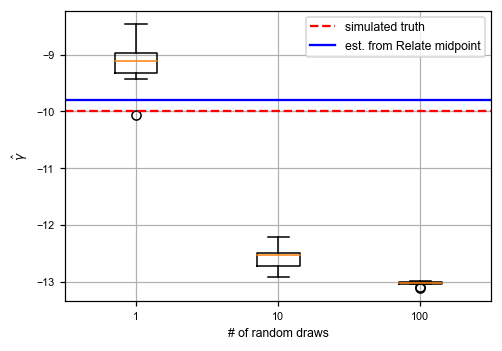

In [307]:
# plt.plot([1,5,10,20,50,200],[-62,-90,-92,-98,-105,-105.5],'k-o'); plt.grid(); plt.xlabel('# of random draws'); plt.ylabel(r'$\hat \gamma$'); plt.axhline(-100,color='red',ls='--')
# plt.boxplot(np.vstack((gamest,[-106.46879490781772, -106.63533318585628, -106.59984482503617, -105.71164004240123, -106.60735265236947, -105.96117457813611, -105.4330728291148, -106.35381183019143, -105.9841342938603, -106.17026426936992, -105.6041233148638, -105.94080087277358])).T); plt.xticks(ticks=range(1,5),labels=[2,10,50,200]); plt.xlabel('# of random draws'); plt.ylabel(r'$\hat \gamma$'); plt.axhline(-100,color='red',ls='--',label='simulated truth'); plt.grid(); plt.axhline(-62,color='b',label='est. from Relate midpoint'); plt.legend(loc='center right')
plt.boxplot(gamest[:,:10].T+5.98); plt.xticks(ticks=range(1,4),labels=[1,10,100]); plt.xlabel('# of random draws'); plt.ylabel(r'$\hat \gamma$'); plt.axhline(-10,color='red',ls='--',label='simulated truth'); plt.grid(); plt.axhline(-9.8,color='b',label='est. from Relate midpoint'); plt.legend(loc='upper right')

## Reading in results from files produced on midway3

In [420]:
# with open('list_of_gammas.txt', 'r') as file:
#     listofgam = file.read()
# listofgam = listofgam.split('\n')

# reswage = np.zeros((20,3)) # one with true age, one with Relate midpoint est, one with 100 draws from imp samp
for ig, g in enumerate(listofgam[20:]):
    if float(g)<5:
        theta = 100
    elif (float(g)>5) & (float(g)<50):
        theta = 200
    else:
        theta = 400

    dft = pd.read_csv('msselfiles/relfiles/sumfiles/RelConstantSize{}_id{}.9.full_out.txt'.format(g,ig+1),sep='\t',header=None,names=['','Xl','s','al','id','age_begin','age_end'])
    dft['sXl'] = (dft['Xl']*200).astype('int')
    dft['al'] = 80000+1 - dft['al']
    dft['al'] = dft['al'].astype('int')
    dft['age_mid'] = 0.5*(dft['age_begin']+dft['age_end']).astype('int')
    dft = dft.iloc[:,1:]
    datt = dft.to_numpy()

    SMS = np.zeros((80000,200+1),dtype='int16')
    mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
    for i in range(len(datt)):
        SMS[int(datt[i,2]),int(datt[i,6])] += 1
    SMSmask = np.ma.array(SMS,mask=mask)
    reswage[ig%20,0] += sp.optimize.minimize_scalar(get_ll_freqageconstant_notfm,args=({'sms':SMSmask,'theta':theta,'N':10000,'gens':80000},200)).x

    SMS = np.zeros((int(np.max(dft['age_end'])),200+1),dtype='int16')
    mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
    for i in range(len(datt)):
        SMS[int(datt[i,7]),int(datt[i,6])] += 1
    SMSmask = np.ma.array(SMS,mask=mask)
    reswage[ig%20,1] += sp.optimize.minimize_scalar(get_ll_freqageconstant_notfm,args=({'sms':SMSmask,'theta':theta,'N':10000,'gens':int(np.max(dft['age_end']))},200)).x

    adat = np.zeros((len(datt),100),dtype='int') 
    for i in range(len(adat)):
        try:
            adat[i,:] = rng.integers(int(datt[i,4])+1,int(datt[i,5]),size=numdraws)
        except:
            adat[i,:] = rng.integers(1,int(datt[i,2])+1,size=numdraws)
    reswage[ig%20,2] += sp.optimize.minimize_scalar(get_ll_import_samp,args=({'fdat':np.int_(datt[:,6]),'adat':adat,'gens':int(np.max(adat))+1,'N':10000,'theta':theta},200)).x

    print(g, theta, reswage[ig%20,:])

100 400 [-192.604 -112.501 -174.938]
74.989 400 [-135.632 -91.057 -138.047]
56.423 400 [-117.945 -64.950 -107.275]
42.17 200 [-85.812 -61.235 -88.747]
31.623 200 [-64.317 -42.652 -61.943]
23.714 200 [-42.102 -29.660 -43.824]
17.783 200 [-38.179 -28.647 -37.189]
13.335 200 [-28.646 -22.754 -28.749]
10 200 [-19.052 -15.850 -19.667]
7.499 200 [-14.324 -13.847 -15.793]
5.623 200 [-10.874 -10.022 -11.509]
4.217 100 [-8.373 -7.816 -9.310]
3.162 100 [-5.914 -6.126 -6.609]
2.371 100 [-4.132 -4.294 -4.480]
1.778 100 [-3.353 -3.750 -3.839]
1.334 100 [-2.724 -3.114 -3.218]
1 100 [-2.705 -3.079 -3.135]
0.332 100 [-0.880 -1.228 -1.262]
0.005 100 [-0.145 -0.312 -0.339]
0 100 [-0.245 -0.356 -0.395]
100 400 [-299.775 -187.244 -281.151]
74.989 400 [-209.766 -129.490 -201.527]


KeyboardInterrupt: 

([<matplotlib.axis.XTick at 0x165f793f0>,
 [Text(1, 0, '1'), Text(100, 0, '100'), Text(10000, 0, '10000')])

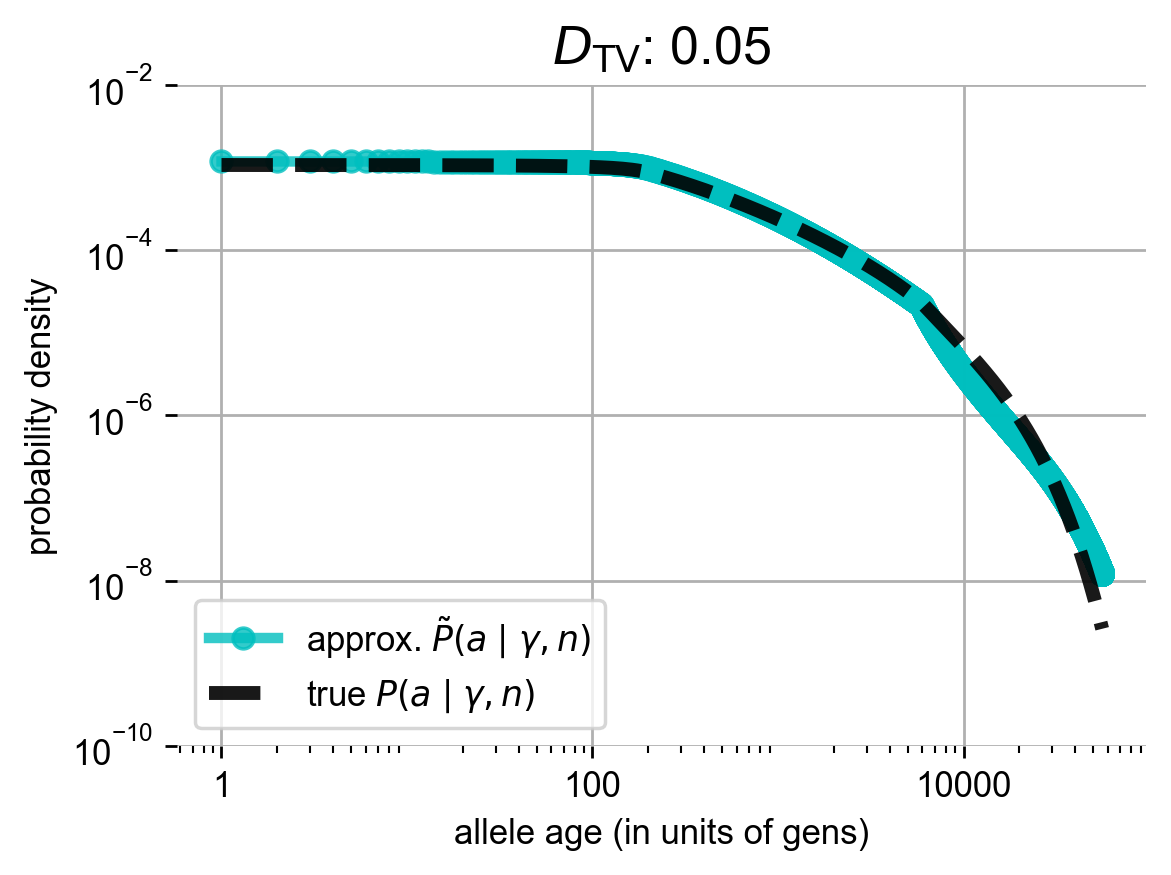

In [40]:
# demo = np.loadtxt("/Users/vivaswatshastry/selCoefEst/PReFerSims/simfiles/AFRlike_demo.txt", delimiter=" ", dtype='int')
# Nc = []
# [Nc.append([demo[n,0]]*demo[n,1]) for n in np.arange(len(demo))]
# Nc = np.array(list(it.chain(*Nc))); Nc = Nc[::-1]

# fsf0 = moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(2000,gamma=0))*400
# for i in range(1,len(demo)):
#     fsf0.integrate([demo[i,0]/10000], demo[i,1]/20000, gamma=0, dt_fac=1e-3, theta=400)
# fsf0 = fsf0.project([200])

# fstAFR0 = run_mom_iterate_changing4(200, 0, Nc/2, 400)

g = -5
expresamp, fsa20 = get_Kl_div(g, fstAFR0, fsf0, 400)
# 0.5*np.sum(np.abs(expresamp/expresamp.sum()-fsa20.sum(axis=1)/fsa20.sum()))

plt.figure(dpi=250)
plt.plot(np.arange(1,len(Nc)),expresamp[1:-1]/expresamp.sum(),'co-',linewidth=3,alpha=0.8,label=r'approx. $\tilde{P} \left(a \mid \gamma, n\right)$')
plt.plot(np.arange(1,len(Nc)),fsa20[1:-1].sum(axis=1)/fsa20.sum(),'k--',alpha=0.9,linewidth=4,label=r'true $P \left(a \mid \gamma, n\right)$'); 
plt.grid(); plt.legend(loc='lower left',fontsize=10); plt.xlabel(r'allele age (in units of gens)',fontsize=10); plt.ylabel('probability density',fontsize=10); 
# plt.title(r'KL divergence: {:.3f}'.format(sp.stats.entropy(expresamp,fsa20.sum(axis=1))),fontsize=10); 
plt.title(r'$D_\mathrm{{TV}}$: {:.2f}'.format(0.5*np.sum(np.abs(expresamp/expresamp.sum()-fsa20.sum(axis=1)/fsa20.sum()))), fontsize=15)
plt.box(False); plt.loglog(); plt.ylim((1e-10,1e-2)); plt.yticks(fontsize=10)
plt.xticks([1,100,10000],labels=[1,100,10000],fontsize=10,)

In [32]:
def get_Kl_div(g, fsa0, sfs0, theta):
    sfs20 = moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(2000,gamma=g))*400
    for i in range(1,len(demo)):
        sfs20.integrate([demo[i,0]/10000], demo[i,1]/20000, gamma=g, dt_fac=1e-3, theta=400)
    sfs20 = sfs20.project([200]) 

    fsa20 = run_mom_iterate_changing4(200, g/10000, Nc/2, 400)

    expresamp = np.sum(np.multiply(sfs20/sfs0,fsa0[:,None]),axis=(1,2))

    return [expresamp, fsa20]

10

In [29]:
# demo = np.loadtxt("/Users/vivaswatshastry/selCoefEst/PReFerSims/simfiles/CEUlike_demo.txt", delimiter=" ", dtype='int')
# Nc = []
# [Nc.append([demo[n,0]]*demo[n,1]) for n in np.arange(len(demo))]
# Nc = np.array(list(it.chain(*Nc))); Nc = Nc[::-1]
# plt.figure(dpi=200)
# plt.plot(Nc,linewidth=3,color='grey'); plt.semilogx(); plt.xlabel('gens ago'); plt.ylabel(r'diploid pop. size ($N$)'); plt.grid(); plt.box(False); #plt.savefig('figs/AFRlike_demo.png',dpi=300,bbox_inches='tight')

# Nc = np.concatenate((np.repeat(1000,1000),np.repeat(200,200)))

# fsf = moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(2000,gamma=25))*400
# for i in range(1,len(demo)):
#     fsf.integrate([demo[i,0]/10000], demo[i,1]/20000, gamma=25, dt_fac=1e-3, theta=400)
# fsf = fsf.project([200])
## moments.Plotting.plot_1d_fs(fsf)

## 2m22s for 2n=100 & full Nc
# %timeit fstAFR = run_mom_iterate_changing4(200, -0.001, Nc/2, 400) # 6-8 s for 10k gens & 2n=200
# run_mom_iterate_changing4(200, -10/10000, Nc/2, 400)
# %time fsa0 = run_mom_iterate_constant(80000, 400, 0/10000, 10000, 400)[::-1] # 0.12 s for 10k gens & 2n=200
# fstAFR2 = run_mom_iterate_changing(200, -10/10000, Nc, 400, {})
# plt.imshow(fstAFR[:,1:-1],aspect='auto',cmap='OrRd',norm=colors.LogNorm(vmin=1e-10)); plt.ylabel('gens ago'); plt.xlabel('sample frequency'); plt.colorbar(); plt.show()

# plt.plot(fsf[1:-1],'-ob',label='moments',alpha=0.5); plt.plot(fstAFR.sum(axis=0)[1:-1]/10000,'-+r',label=r'my code',alpha=0.5); plt.xlabel('sample allele frequency'); plt.legend(); plt.semilogy(); plt.grid(); plt.box(False); 

array([[ 10000,  50000],
       [ 28948,   5715],
       [ 32326,     10],
       [ 38110,     10],
       [ 44932,     10],
       [ 52972,     10],
       [ 62452,     10],
       [ 73630,     10],
       [ 86806,     10],
       [102342,     10],
       [120658,     10],
       [142250,     10],
       [167708,     10],
       [197722,     10],
       [233108,     10],
       [274826,     10],
       [324010,     10],
       [381998,     10],
       [450362,     10],
       [530962,     10],
       [625984,     10],
       [738014,     10],
       [834302,      5]])

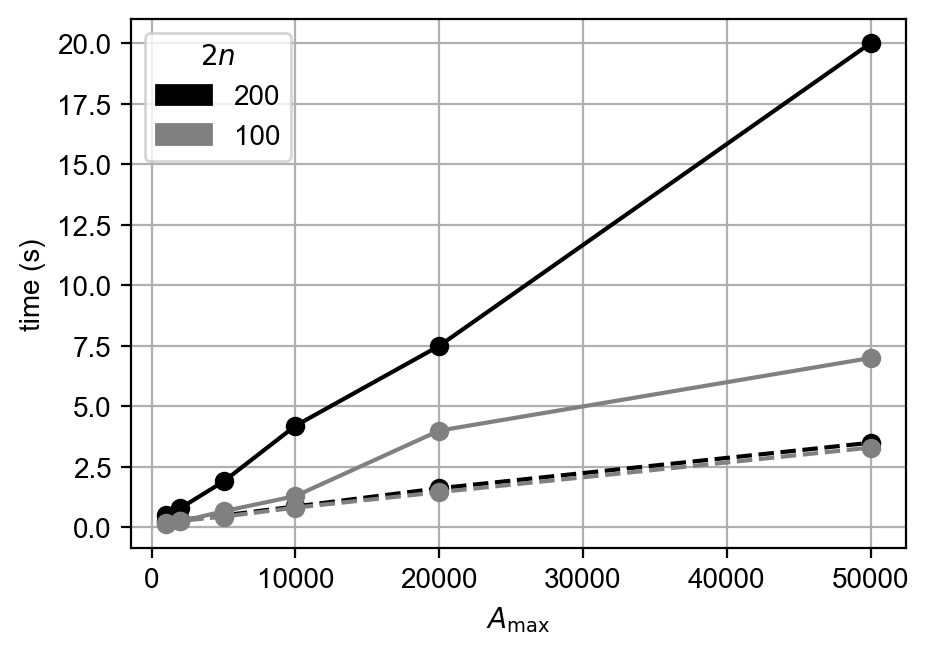

In [274]:
import matplotlib.patches as mpatches
plt.figure(dpi=200); plt.grid(); 
plt.plot([1000, 2000, 5000, 10000, 20000, 50000], [0.5, 0.8, 1.9, 4.2, 7.5, 20],'-ko',label='old'); plt.xlabel(r'$A_{\mathrm{max}}$'); 
plt.plot([1000, 2000, 5000, 10000, 20000, 50000], [0.25, 0.32, 0.5, 0.87, 1.62, 3.5],'--ko',label='new'); #plt.loglog(); plt.xlabel(r'$A_{\mathrm{max}}$'); 
n200 = mpatches.Patch(color='k', label='200'); n100 = mpatches.Patch(color='grey', label='100'); 
plt.legend(handles=[n200,n100],title=r'$2n$'); 
# plt.figure(dpi=200); plt.title("\"new method\" "); plt.grid(); 
plt.plot([1000, 2000, 5000, 10000, 20000, 50000], [0.16, 0.25, 0.67, 1.3, 4, 7],'-o',color='grey'); plt.ylabel('time (s)')   
plt.plot([1000, 2000, 5000, 10000, 20000, 50000], [0.2, 0.27, 0.45, 0.82, 1.46, 3.3],'--o',color='grey'); #plt.legend(title='2n'); plt.ylabel(r'time (for a single $i$, s)')   
print

In [4]:
## using the new method on the AFR demography
demo = np.loadtxt("/Users/vivaswatshastry/selCoefEst/PReFerSims/simfiles/AFRlike_demo.txt", delimiter=" ", dtype='int')
ct = time.time()
fsf = moments.LinearSystem_1D.steady_state_1D(200, gamma=-10, theta=400)
demo[0,1] = 4000
sfas2 = {}
sfas2[0] = moments.Integration_nomig.integrate_nomig_viv(fsf.data, [1], demo[0,1]/demo[0,0], gamma=-10, dt_fac=1/demo[0,1], theta=400)
for ep in range(1,len(demo)):
    sfas2[ep] = moments.Integration_nomig.integrate_nomig_viv(sfas2[ep-1][-1], [demo[ep,0]/demo[0,0]], demo[ep,1]/demo[ep,0], gamma=-10, dt_fac=1/demo[ep,1], theta=200)
for i in range(1, 200):
    age, X1 = moments.Integration_nomig.calculate_page_condi(sfas2[len(demo)-1], i, [demo[len(demo)-1,0]/demo[0,0]], demo[len(demo)-1,1]/demo[0,0], gamma=-10, dt_fac=1/(demo[len(demo)-1,1]-1), theta=200)
    for e in range(0,ep)[::-1]:
        age, X1 = moments.Integration_nomig.calculate_page_condi(sfas2[e], age, [demo[e,0]/demo[0,0]], demo[e,1]/demo[0,0], gamma=-10, dt_fac=1/(demo[e,1]-1), theta=400, X1=X1)
    # print(len(age))
print(time.time() - ct)
# %time fsf = moments.LinearSystem_1D.steady_state_1D(100, gamma=5, theta=400)
# %time sfas = moments.Integration_nomig.integrate_nomig_viv(fsf.data, [1.], 2, gamma=5, dt_fac=.5001e-3, theta=400)
# %time sfas2 = moments.Integration_nomig.integrate_nomig_viv(sfas[-1], [2.], 0.5, gamma=5, dt_fac=2.001e-3, theta=200)
# %time age, X1 = moments.Integration_nomig.calculate_page_condi(sfas2, 10, [2.], 0.5, gamma=5, dt_fac=2.001e-3, theta=200)
# %time age, _ = moments.Integration_nomig.calculate_page_condi(sfas, age, [1.], 2., gamma=5, dt_fac=.5001e-3, theta=400, X1=X1)

65.40759682655334


In [10]:
# df1 = df1.drop(df1[df1.al>50000].index)
# cumsumage[:10], np.cumsum(fsa0[:10,1:-1])

50

In [377]:
df1 = pd.DataFrame()
for i in range(1,11):
    df = pd.read_csv("PReFerSims/outfiles/AFRlike10.{}.full_out.txt".format(i),sep='\t',header=None,names=['','Xl','s','al','id'])
    # df = pd.read_csv("PReFerSims/outfiles/ConstantSize0.0_n400_sim{}.3.full_out.txt".format(i),sep='\t',header=None,names=['','Xl','s','al','id'])
    df['sXl'] = df['Xl']*400 
    df['al'] = len(Nc)+1 - df['al']
    df1 = pd.concat([df1,df])
#     # df1 = pd.concat([df1,df.loc[df['sXl']==10]])

# from statsmodels.distributions.empirical_distribution import ECDF 
age_ecdf = ECDF(df1['al']); 
totage = fstAFR[:,1:-1].sum(); cumsumage = [fstAFR[:a,1:-1].sum()/totage for a in np.arange(1,len(Nc)+1)]
pk = [fstAFR[a,1:-1].sum()/totage for a in np.arange(1,len(Nc)-1)]
cstm = sp.stats.rv_discrete(name='cstm', values=(np.arange(1,len(Nc)-1),pk/np.sum(pk)))
# totage = fsa0[:,1:-1].sum(); cumsumage = np.cumsum(fsa0[:80001,].sum(axis=1))/totage # [fsa0[:a,1:-1].sum()/totage for a in np.arange(1,50001)]
# for a in range(1,80000):
#     totsum += fsa0[a,1:-1].sum()
#     cumsumage.append(totsum/totage)
# pk = [fsa0[a,1:-1].sum()/totage for a in np.arange(1,80000-1)]
# cstm = sp.stats.rv_discrete(name='cstm', values=(np.arange(1,80000-1),pk/np.sum(pk)))
sp.stats.kstest(df1['al'].values,cstm.cdf) # 0.0065 for AFR, 0.006 for constant
# plt.figure(figsize=(6,4),dpi=250)
# plt.plot(np.arange(1,80001),age_ecdf(np.arange(1,80001)),color='green',alpha=0.8,linewidth=3,label='ECDF from sim.'); plt.plot(np.arange(1,80001),cumsumage,color='purple',alpha=0.8,linewidth=3,ls='dashed',label=r'exp. from our method'); plt.xlabel('allele age (in units of gens)'); plt.ylabel('CDF'); 
# plt.plot(np.arange(1,55920),np.cumsum(age/np.sum(age)),ls='-.',linewidth=3,color='goldenrod',alpha=0.7,label='exp. from new method'); 
# plt.legend(); plt.semilogx(); plt.grid(); plt.box(False);
# plt.savefig('figs/ecdf_constant.png')
# plt.figure(figsize=(6,4),dpi=120)
# plt.plot(np.arange(1,80001),age_ecdf(np.arange(1,80001)),color='green',alpha=0.8,linewidth=3,label='ECDF from sim.'); plt.plot(np.arange(1,80001),cumsumage,color='purple',alpha=0.8,linewidth=3,ls='--',label=r'exp. from SFAS'); plt.xlabel('age (gens)'); plt.ylabel('CDF'); plt.legend(); plt.semilogx(); plt.title(r'Constant-size demography $(\gamma = 0)$'); plt.grid(); plt.box(False); plt.savefig('figs/ecdf_constant.png')
## what about comparing to the moments sfs-based result?
# totageAFR = fstAFR[:,1:-1].sum(); cumsumageAFR = [fstAFR[::-1][:a,1:-1].sum()/totageAFR for a in np.arange(1,20001)]
# plt.scatter(cumsumage[1:20001],cumsumageAFR,color='k',alpha=0.3); plt.xlabel('exp from moments (constant)'); plt.ylabel('exp from moments (AFR-like)'); plt.axline((1,1),slope=1); plt.loglog(); plt.grid()

KstestResult(statistic=0.006202954713695252, pvalue=0.6996170033621384)

In [63]:
# import msprime, pyslim
sweep_model = msprime.SweepGenicSelection(
    position= 2.0,  # middle of chrom
    start_frequency=1.0 / (2 * 20000),
    end_frequency=0.75,
    s=0.0022,
    dt=1e-6)
reps = msprime.sim_ancestry(
        40/2,
        model=[sweep_model],
        population_size=20000/2.0,
        recombination_rate=0.0,
        sequence_length=10)
demm = msprime.Demography.from_tree_sequence(reps)
for pop in demm.populations:
    pop.initial_size = 20000 / 2.0 
tsfull = pyslim.recapitate(reps, demography= demm, recombination_rate=0.0)
firsttree = reps.first()

numleaves = 0
for k in firsttree.leaves():
    numleaves = numleaves + 1
IsDerived = [0] * numleaves
for leaff in range(numleaves):
    currleaf = leaff
    IsDerived[leaff] = currleaf
    while firsttree.parent(currleaf) > -1:
        currleaf =  firsttree.parent(currleaf)
        IsDerived[leaff] = currleaf

IsDerived = np.equal(IsDerived, [max(set(IsDerived), key = IsDerived.count)]) + 0
firsttree = tsfull.first()
AncTimes = []
DerTimes = []
CROSSNODE = []
for i in range(len(IsDerived)-1):
    for j in range(i + 1,len(IsDerived)):
        NodeTime = firsttree.mrca(i, j)
        if IsDerived[i] == 1 and IsDerived[j] == 1:
            DerTimes.append(NodeTime)
        elif IsDerived[i] == 0 and IsDerived[j] == 0:
            AncTimes.append(NodeTime)
        else:
            CROSSNODE.append(NodeTime)
            
AncTimes = np.unique(AncTimes)
DerTimes = np.unique(DerTimes)
CROSSNODE = np.unique(CROSSNODE)
NewAncTimes = [0.0] * len(AncTimes)
NewDerTimes = [0.0] * len(DerTimes)
NewCROSSNODE = [0.0] * len(CROSSNODE)

#convert from nodes to times
for i in range(len(AncTimes)):
    if AncTimes[i] < 0:
        print("PROBLEM2")
    else:
        NewAncTimes[i] = float(firsttree.time(AncTimes[i]))
for i in range(len(DerTimes)):
    NewDerTimes[i] = float(firsttree.time(DerTimes[i]))
for i in range(len(CROSSNODE)):
    NewCROSSNODE[i] = float(firsttree.time(CROSSNODE[i]))
NewDerTimes.append(NewCROSSNODE[0])
NewAncTimes.sort()
NewDerTimes.sort()
if len(NewDerTimes) + len(NewAncTimes) + 1 != NUMBEROFLEAVESTOSAMPLE:
    print("PROBLEM7")
AncString = ""
DerString = ""
for time in NewAncTimes:
    AncString = AncString + str(time)  + ","
for time in NewDerTimes:
    DerString = DerString + str(time) + ","

In [67]:
f = open("/Users/vivaswatshastry/CLUES2/Times2.txt", "w")
f.writelines(DerString[0:(len(DerString)-1)]+ "\n" + AncString[0:(len(AncString)-1)] + "\n") # added indexing to remove comma at the end
f.close()

In [644]:
# gamest = np.zeros((25,3)); covrg = np.zeros((25,)) # min-max, med-med, all branches-all muts
pc=[]
for n, id in enumerate(range(1,500,20)):

    dft = pd.read_csv('~/selCoefEst/PReFerSims/msselfiles/relfiles/sumfiles/RelConstantSize100_id{}.9.full_out.txt'.format(id),sep='\t',header=None,names=['','Xl','s','al','id','age_begin','age_end'])
    dft['sXl'] = (dft['Xl']*200).astype('int')
    dft['al'] = 80000+1 - dft['al']
    dft['al'] = dft['al'].astype('int')
    dft.dropna(inplace=True)

    # adat = np.zeros((len(dft),numdraws),dtype='int') 
    # for i in range(len(dft)):
    #     ab = np.array(dft['age_begin'].iloc[i].split(','),dtype='float')
    #     ae = np.array(dft['age_end'].iloc[i].split(','),dtype='float')
    #     adat[i,:] = rng.integers(int(np.min(ab))+1,int(np.max(ae)),size=numdraws)
    # gamest[n,0] = sp.optimize.minimize_scalar(get_ll_import_samp,args=({'fdat':dft['sXl'].values,'adat':adat,'gens':int(np.max(adat))+1,'N':10000,'theta':10},200)).x

    # adat = np.zeros((len(dft),numdraws),dtype='int') 
    # for i in range(len(dft)):
    #     ab = np.array(dft['age_begin'].iloc[i].split(','),dtype='float')
    #     ae = np.array(dft['age_end'].iloc[i].split(','),dtype='float')
    #     adat[i,:] = rng.integers(int(np.median(ab))+1,int(np.median(ae)),size=numdraws)
    # gamest[n,1] = sp.optimize.minimize_scalar(get_ll_import_samp,args=({'fdat':dft['sXl'].values,'adat':adat,'gens':int(np.max(adat))+1,'N':10000,'theta':10},200)).x

    # adat = np.zeros((len(dft),200,numdraws),dtype='int')
    # for i in range(len(dft)):
    #     ab = np.array(dft['age_begin'].iloc[i].split(','),dtype='float')
    #     ae = np.array(dft['age_end'].iloc[i].split(','),dtype='float')
    #     for j in range(200):
    #         adat[i,j,:] = rng.integers(int(ab[j]),int(ae[j])+1,size=numdraws)
    # gamest[n,2] = sp.optimize.minimize_scalar(get_ll_import_samp_pos,args=({'fdat':dft['sXl'].values.astype('int'),'adat':adat[:,:200,:],'gens':int(np.max(adat))+1,'N':10000,'theta':10},200)).x

    # covrg[n] = np.sum((dft['al']>np.array([np.min(np.array(dft['age_begin'].iloc[i].split(','),dtype='float')) for i in range(len(dft))])) & (dft['al']<np.array([np.max(np.array(dft['age_end'].iloc[i].split(','),dtype='float')) for i in range(len(dft))])))/len(dft)
    # pc.append([1-sp.stats.uniform.sf(dft['al'].iloc[i],np.min(np.array(dft['age_begin'].iloc[i].split(','),dtype='float')),np.max(np.array(dft['age_end'].iloc[i].split(','),dtype='float'))) for i in range(len(dft))])
    pc.append([1-sp.stats.uniform.sf(dft['al'].iloc[i],dft['age_begin'].iloc[i],dft['age_end'].iloc[i]) for i in range(len(dft))])
    # plt.hist(pc); plt.axvline(np.median(pc),color='r'); plt.xlabel('percentile of true value in sampled age range'); plt.xlim((0,1))

    print(gamest[n,], covrg[n])

[13.976 19.146 20.037] 0.018343471402910427
[12.945 18.493 19.148] 0.016707417362766264
[15.309 19.932 21.312] 0.02558166918046001


FileNotFoundError: [Errno 2] No such file or directory: '/Users/vivaswatshastry/selCoefEst/PReFerSims/msselfiles/relfiles/sumfiles/RelConstantSize100_id61.9.full_out.txt'

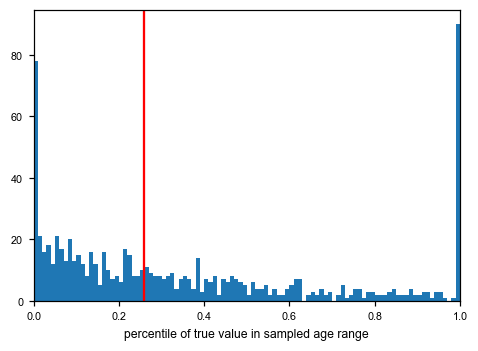

In [645]:
# gamest[:,2] = np.concatenate((np.array([20.03686689619183, 19.148217501525217, 21.31152189359751, 21.958105157661322, 26.332858783175904]), np.random.normal(loc=22,scale=3,size=20)))
# plt.boxplot(gamest, labels=['min begin-max end','med begin-med end','all branches']); plt.axhline(100,color='red',ls='-'); plt.semilogy(); plt.ylabel(r'$\hat \gamma$'); plt.show()
# plt.hist(covrg*100); plt.xlabel('coverage'); plt.xlim((0,10)); plt.show()
plt.hist([item for sublist in pc for item in sublist],bins=100); plt.axvline(np.median([item for sublist in pc for item in sublist]),color='red'); plt.xlabel('percentile of true value in sampled age range'); plt.xlim((0,1)); plt.show()

In [ ]:
def get_ll_import_samp(g, opts, n=200):
    # adat is a matrix S x #, where S is total seg sites & # is resampled ages
    # fdat is a vector S
    fsa = run_mom_iterate_constant(opts['gens'], n, g/opts['N'], opts['N'], opts['theta'], {})[::-1]
    fsa[fsa<0] = -fsa[fsa<0]
    S = opts['adat'].shape[0]

    fsa0 = run_mom_iterate_constant(opts['gens'], n, 0.0, opts['N'], opts['theta'], {})[::-1]

    res = sp.stats.poisson.logpmf(S,fsa.sum())
    fsasum = np.sum(fsa)
    fsasum0 = np.sum(fsa0)

    res1 = 0
    temp = np.zeros(opts['adat'].shape[1])
    for l in range(S):
        for i in range(len(temp)):
            temp[i] = np.log(fsa[opts['adat'][l,i],opts['fdat'][l]]/np.sum(fsa[opts['adat'][l,i],:])) + np.log(np.sum(fsa[opts['adat'][l,i],:])/fsasum) - np.log(np.sum(fsa0[opts['adat'][l,i],:])/fsasum0)
        res1 += sp.special.logsumexp(temp,b=1/len(temp))

    return -(res+res1)

In [133]:
def get_Kl_div_AFR(g, fsa0, sfs0, fsa20, theta):
    
    sfs20 = moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(800,gamma=g))*theta
    for i in range(1,len(demo)):
        sfs20.integrate([demo[i,0]/10000], demo[i,1]/20000, gamma=g, dt_fac=1e-3, theta=theta)
    sfs20 = sfs20.project([500])

    if fsa20 is None:
        fsa20 = run_mom_iterate_changing4(500, g/10000, Nc[:50000]/2, theta)

    expresamp = np.sum(np.multiply(sfs20/sfs0,fsa0[:,None]),axis=(1,2))

    plt.figure(dpi=150)
    plt.plot(np.arange(1,1000)[::-1],expresamp[-1000:-1]/expresamp.sum(),'r+-',label=r'resampled from $\mathbb{E}[X_{a.} \mid \gamma=0]$'); plt.plot(np.arange(1,1000)[::-1],fsa20.sum(axis=1)[-1000:-1]/fsa20.sum(),'k',label=r'$\mathbb{E}[X_{a} \mid \gamma=$' + '{}]'.format(int(g))); plt.grid(); plt.legend(); plt.xlabel('allele age (gens)'); plt.ylabel('probability'); plt.title('KL divergence: {:.3f}'.format(sp.stats.entropy(expresamp,fsa20.sum(axis=1)))); plt.box(False); #plt.semilogx()
    plt.savefig('figs/kldiv_{}.jpg'.format(int(g)))

    # return [expresamp, fsa20]
    return sp.stats.entropy(fsa20.sum(axis=1)[:50000],expresamp)

[]

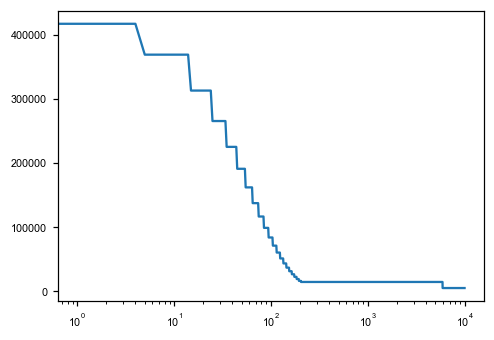

In [114]:
# demo = np.loadtxt("/Users/vivaswatshastry/selCoefEst/PReFerSims/simfiles/CEUlike_demo.txt", delimiter=" ", dtype='int')
# Nc = []
# [Nc.append([demo[n,0]]*demo[n,1]) for n in np.arange(len(demo))]
# Nc = np.array(list(it.chain(*Nc))); Nc = Nc[::-1]
# plt.plot(Nc/2); plt.semilogx()

# fsa0 = run_mom_iterate_constant(40000, 500, 0/10000, 10000, 200)[::-1]
# fsa1 = run_mom_iterate_constant(40000, 500, 1/10000, 10000, 200)[::-1]
# fsa10 = run_mom_iterate_constant(40000, 500, 10/10000, 10000, 200)[::-1]
# fsa50 = run_mom_iterate_constant(40000, 500, 50/10000, 10000, 200)[::-1]

# fsaAFR0, fsaAFR1, fsaAFR10, fsaAFR50 = Parallel(n_jobs=4)(delayed(run_mom_iterate_changing4)(500, g/10000, Nc/2, 200) for g in [0,1,10,50])
# fsaAFR50 = run_mom_iterate_changing4(500, -50/10000, Nc/2, 200)

In [145]:
# fsf0 = moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(500,gamma=0))*400
# for i in range(1,len(demo)):
#     fsf0.integrate([demo[i,0]/10000], demo[i,1]/20000, gamma=0, theta=400)
# gam = np.append(-np.append(np.linspace(0.0, 1.0, num=5)**np.exp(1),np.geomspace(100,1,20,endpoint=False)[::-1])[::-1][:-1], np.append(np.linspace(0.0, 1.0, num=5)**np.exp(1),np.geomspace(100,1,20,endpoint=False)[::-1]))
# KLdiv10k = [0.06894083747046185,0.052352951475797056,0.043783286837395734,0.03894732879766519,0.035305294165875495,0.031535387398206015,0.027058873756424073,0.02184025180155121,0.016518500379776896,0.012353344999739902,0.010258689770385326,0.009817028571488081,0.009730170816666515,0.009010579534910596,0.0075096211300796495,0.0056364539313377045,0.0038680271114094073,0.002477433188401181,0.001513295885737967,0.0008988596387082114,0.0005272701402288678,8.755147084552072e-05,8.083521265845359e-06,1.6024652478737172e-07,-9.758537757578047e-08,2.477149714696556e-07,6.571824317561613e-06,4.768382780671139e-05,0.00015309010509720116,0.00020724986272981734,0.0002841929453793416,0.0004119922386109304,0.0006526647531205701,0.0011136167878017535,0.0019394480199534196,0.003276183648177976,0.005223911937897923,0.007833238348915372,0.0113493479214064,0.017307345096079684,0.03129915250376466,0.06471728124568772,0.12397182190366815,0.19172134077071423,0.24652946610481147,1.2052462196976255,np.inf,np.inf,np.nan]
# KLdiv50k = [0.07000437281587475, 0.05352117055114739, 0.04509338156493018, 0.04044350836036718, 0.03704020190955789, 0.033571668179869, 0.029460303150308204, 0.024595750946379485, 0.019341193528186505, 0.014626318940203114, 0.01162693418609578, 0.010957067119430381, 0.012222352958089128, 0.01427371040483571, 0.01568577821987235, 0.015428941688635851, 0.013467664135293518, 0.010591461309911818, 0.007689742914348034, 0.0052797655916258235, 0.0034953287146520223, 0.0007634000044189345, 8.323584141454887e-05, 1.6836425009749615e-06, -9.881563032904638e-08, 1.9292296049406296e-06, 8.076758009343066e-05, 0.0006966103052794674, 0.0029533401489251817, 0.004392727808418453, 0.006427814629397301, 0.009275639650947104, 0.013313301729333241, 0.019285902782077348, 0.02859778365177306, 0.043452897392521325, 0.06641935302243245, 0.09936824687179822, 0.14329829284467557, 0.20092942787840823, 0.2803266995124438, 0.39207102798213844, 0.5359167947565334, 0.6905150284430707, 0.8193537823794961, 2.0408653909245786, np.inf, np.inf, np.nan]
# KLdiv50k = []
# for g in gam:
#     KLdiv50k.append(get_Kl_div_AFR(g, fsaAFR0[:50000,:], fsf0, None, 400))
#     print(KLdiv50k[-1])
# plt.plot(gam,KLdiv50k,'-o',color='red'); plt.plot(gam,KLdiv10k,'-o',color='red',alpha=0.5)

[0.07000437281587475, 0.05352117055114739, 0.04509338156493018, 0.04044350836036718, 0.03704020190955789, 0.033571668179869, 0.029460303150308204, 0.024595750946379485, 0.019341193528186505, 0.014626318940203114, 0.01162693418609578, 0.010957067119430381, 0.012222352958089128, 0.01427371040483571, 0.01568577821987235, 0.015428941688635851, 0.013467664135293518, 0.010591461309911818, 0.007689742914348034, 0.0052797655916258235, 0.0034953287146520223, 0.0007634000044189345, 8.323584141454887e-05, 1.6836425009749615e-06, -9.881563032904638e-08, 1.9292296049406296e-06, 8.076758009343066e-05, 0.0006966103052794674, 0.0029533401489251817, 0.004392727808418453, 0.006427814629397301, 0.009275639650947104, 0.013313301729333241, 0.019285902782077348, 0.02859778365177306, 0.043452897392521325, 0.06641935302243245, 0.09936824687179822, 0.14329829284467557, 0.20092942787840823, 0.2803266995124438, 0.39207102798213844, 0.5359167947565334, 0.6905150284430707, 0.8193537823794961, 2.0408653909245786, i

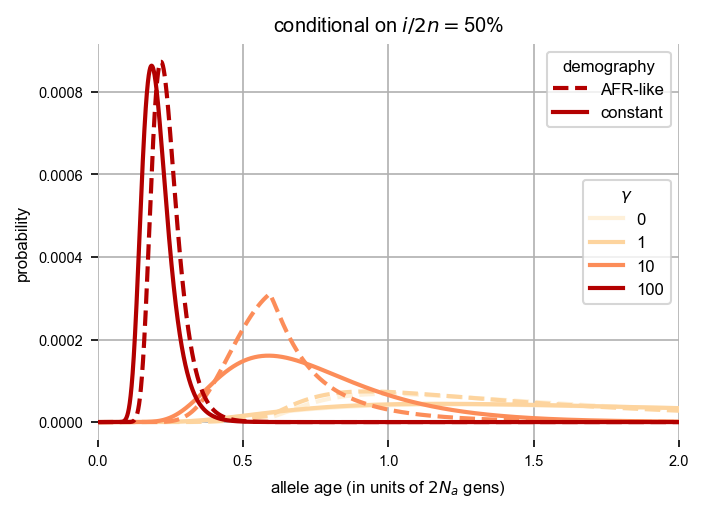

In [74]:
# plt.imshow(fsaAFR50,aspect='auto',norm=colors.LogNorm(vmin=1e-10,vmax=1)); plt.colorbar()
# cols = ['#fef0d9','#fdd49e','#fc8d59','#b30000']; gcols = ['#f7f7f7','#d9d9d9','#969696','#525252','#252525']
ix = 250; xlim=20000
plt.figure(dpi=150)
plt.plot(fsaAFR0[:,ix]/np.sum(fsaAFR0[:,ix]),color=cols[0],linewidth=2, ls='--'); l1, = plt.plot(fsa0[:,ix]/fsa0[:,ix].sum(),color=cols[0],linewidth=2,); plt.xlim((0,xlim)); 
plt.plot(fsaAFR1[:,ix]/np.sum(fsaAFR1[:,ix]),color=cols[1],linewidth=2, ls='--'); l2, = plt.plot(fsa1[:,ix]/fsa1[:,ix].sum(),color=cols[1],linewidth=2); 
plt.plot(fsaAFR10[:,ix]/np.sum(fsaAFR10[:,ix]),color=cols[2],linewidth=2, ls='--'); l3, = plt.plot(fsa10[:,ix]/fsa10[:,ix].sum(),color=cols[2],linewidth=2,);
fsaAFR50_250 = [0 if i > 6000 else x for i, x in enumerate(fsaAFR50[:,250])] 
plt.plot(fsaAFR50_250/np.sum(fsaAFR50_250),color=cols[3],linewidth=2, ls='--',label='AFR-like'); l4, = plt.plot(fsa50[:,ix]/fsa50[:,ix].sum(),color=cols[3],linewidth=2,label='constant')
# plt.plot(fsaAFR50[:,ix]/np.sum(fsaAFR50[:,ix]),color=cols[3],linewidth=2, ls='--',label='AFR-like'); l4, = plt.plot(fsa50[:,ix]/fsa50[:,ix].sum(),color=cols[3],linewidth=2,label='constant')
leg1 = plt.legend([l for l in [l1,l2,l3,l4]], [0,1,10,100], loc='center right', title=r'$ \gamma$')
plt.ylabel('probability'); plt.legend(title='demography'); plt.xticks(np.linspace(0,xlim,5),labels=np.linspace(0,xlim,5)/10000); plt.xlabel(r'allele age (in units of $2N_a$ gens)'); plt.grid(); plt.title(r'conditional on $i/2n = ${:d}%'.format(int(ix/5))); plt.box(False); 
plt.gca().add_artist(leg1)

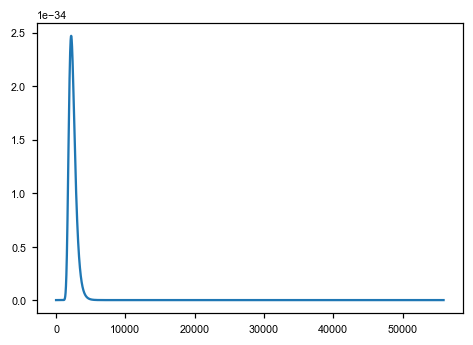

In [72]:
# ix = 200
# plt.plot(fsaAFR50[:,ix]/np.sum(fsaAFR50[:,ix]),color=cols[3],linewidth=2, ls='--',label='AFR-like'); 
# plt.plot([0 if i > 7000 else x for i, x in enumerate(fsaAFR50[:,200])])
# plt.plot([0 if i > 6000 else x for i, x in enumerate(fsaAFR50[:,250])])

In [482]:
# def get_ll_import_samp(g, opts, n=200):
#     # adat is a matrix S x #, where S is total seg sites & # is resampled ages
#     # fdat is a vector S
#     fsa = run_mom_iterate_constant(opts['gens'], n, g/opts['N'], opts['N'], opts['theta'], {})[::-1]
#     fsa[fsa<0] = -fsa[fsa<0]  
#     S = opts['adat'].shape[0]

#     fsa0 = run_mom_iterate_constant(opts['gens'], n, 0.0, opts['N'], opts['theta'], {})[::-1]

#     res = sp.stats.poisson.logpmf(S,fsa.sum())
#     fsasum = np.sum(fsa)
#     fsasum0 = np.sum(fsa0)

#     res1 = 0
#     temp = np.zeros(opts['adat'].shape[1])
#     for l in range(S):
#         for i in range(len(temp)):
#             temp[i] = np.log(fsa[opts['adat'][l,i],opts['fdat'][l]]/np.sum(fsa[opts['adat'][l,i],:])) + np.log(np.sum(fsa[opts['adat'][l,i],:])/fsasum) - np.log(np.sum(fsa0[opts['adat'][l,i],:])/fsasum0)
#         res1 += sp.special.logsumexp(temp,b=1/lezn(temp))

#     return -(res+res1)

# def get_ll_import_samp_pos(g, opts, n=200):
#     # adat is a matrix S x #, where S is total seg sites & # is resampled ages
#     # fdat is a vector S
#     fsa = run_mom_iterate_constant(opts['gens'], n, g/opts['N'], opts['N'], opts['theta'], {})[::-1]
#     fsa[fsa<0] = -fsa[fsa<0]  
#     S = opts['adat'].shape[0]

#     fsa0 = run_mom_iterate_constant(opts['gens'], n, 0.0, opts['N'], opts['theta'], {})[::-1]

#     res = sp.stats.poisson.logpmf(S,fsa.sum())
#     fsasum = np.sum(fsa)
#     fsasum0 = np.sum(fsa0)

#     res1 = 0
#     temp1 = np.zeros(opts['adat'].shape[1]); temp2 = np.zeros(opts['adat'].shape[2])
#     for l in range(S):
#         for i in range(len(temp1)):
#             for j in range(len(temp2)):
#                 temp2[j] = np.log(fsa[opts['adat'][l,i,j],opts['fdat'][l]]/np.sum(fsa[opts['adat'][l,i,j],:])) + np.log(np.sum(fsa[opts['adat'][l,i,j],:])/fsasum) - np.log(np.sum(fsa0[opts['adat'][l,i,j],:])/fsasum0)
#             temp1[i] = sp.special.logsumexp(temp2,b=1/len(temp2))
#         res1 += sp.special.logsumexp(temp1,b=1/len(temp1))

#     return -(res+res1)

In [519]:
# sp.optimize.minimize_scalar(get_ll_import_samp,args=({'fdat':dft['sXl'].values,'adat':adat,'gens':int(np.max(adat))+1,'N':10000,'theta':10},200)).x
# sp.optimize.minimize_scalar(get_ll_import_samp_pos,args=({'fdat':dft['sXl'].values.astype('int'),'adat':adat[:,:,:],'gens':int(np.max(adat))+1,'N':10000,'theta':10},200))
# for g in np.logspace(0,2,5,base=10):
#     print(g, get_ll_import_samp_pos(g, {'fdat':dft['sXl'].values.astype('int'),'adat':adat[:,:1,:50],'gens':int(np.max(adat))+1,'N':10000,'theta':10},200))
# dft['age_mid'] = 0.5*(np.array([np.mean(np.array(dft['age_begin'].iloc[i].split(','),dtype='float')) for i in range(len(dft))]) + np.array([np.mean(np.array(dft['age_end'].iloc[i].split(','),dtype='float')) for i in range(len(dft))]))
# np.array([np.mean(np.array(dft['age_begin'].iloc[i].split(','),dtype='float')) for i in range(len(dft))]), np.array(dft['al'])
# plt.plot(dft['al'],0.5*(dft['age_begin_1t']+dft['age_end_1t']),'gx',alpha=0.5,markersize=3.5); plt.errorbar(dft['al'],0.5*(dft['age_begin_1t']+dft['age_end_1t']),yerr=np.vstack((0.5*(dft['age_begin_1t']+dft['age_end_1t'])-np.array([np.min(np.array(dft['age_begin'].iloc[i].split(','),dtype='float')) for i in range(len(dft))]),np.array([np.max(np.array(dft['age_end'].iloc[i].split(','),dtype='float')) for i in range(len(dft))])-0.5*(dft['age_begin_1t']+dft['age_end_1t']))),fmt='none',color='k',alpha=0.6); plt.axline((0,0),slope=1,color='k'); plt.xlabel('true age (PReFerSim)'); plt.ylabel('estimated age (Relate)'); plt.title(r'$\gamma=100$'); plt.loglog(); plt.ylim((1,1e5)); #plt.autoscale()
# plt.plot(dft['al'],0.5*(dft['age_begin_1t']+dft['age_end_1t']),'gx',alpha=0.5,markersize=3.5); plt.plot(dft['al'],np.median((np.array([np.array(dft['age_end'].iloc[i].split(','),dtype='float') for i in range(len(dft))]) + np.array([np.array(dft['age_begin'].iloc[i].split(','),dtype='float') for i in range(len(dft))]))/2,axis=1),'bo',alpha=0.6,markersize=3); plt.axline((10,10),slope=1); plt.loglog()
# plt.plot(dft['al'],0.5*(dft['age_begin_1t']+dft['age_end_1t']),'o',alpha=0.5,markersize=3.5,color='grey'); plt.errorbar(dft['al'],0.5*(dft['age_begin_1t']+dft['age_end_1t']),yerr=np.vstack((dft['age_begin_1t'],dft['age_end_1t'])),fmt='none',color='k',alpha=0.3); plt.axline((0,0),slope=1,color='k'); plt.xlabel('true age (PReFerSim)'); plt.ylabel('estimated age (Relate)'); plt.title(r'$\gamma=100$'); plt.autoscale()
# np.sum((dft['al']>dft['age_begin_1t']) & (dft['al']<dft['age_end_1t']))/len(dft)
# np.sum((dft['al']>np.array([np.min(np.array(dft['age_begin'].iloc[i].split(','),dtype='float')) for i in range(len(dft))])) & (dft['al']<np.array([np.max(np.array(dft['age_end'].iloc[i].split(','),dtype='float')) for i in range(len(dft))])))/len(dft)
# cnt  = np.zeros(len(dft))
# for i in range(len(dft)):
#     agebegin = np.array(dft['age_begin'].iloc[i].split(','),dtype='float')
#     ageend = np.array(dft['age_end'].iloc[i].split(','),dtype='float')
#     for ab in agebegin:
#         for ae in ageend:
#             if (ab<dft['al'].iloc[i]) & (ae>dft['al'].iloc[i]):
#                 cnt[i] += 1

13.481941384860107

In [627]:
# plt.plot(np.repeat(dft['al'],100).values.reshape((124,100)), adat, 'k.', alpha=0.5); plt.axline((10,10),slope=1,color='k'); plt.xlabel('true age (PReFerSim)'); plt.ylabel('estimated age (Relate)'); plt.title(r'$\gamma=100$'); plt.loglog(); plt.ylim((1,1e5)); #plt.autoscale()
# np.sum((dft['al']>np.min(adat,axis=1))&(dft['al']<np.max(adat,axis=1)))/len(dft)
# plt.hist(adat[50,]); plt.axvline(dft['al'].iloc[50],color='r')
# pc = np.array([1-sp.stats.uniform.sf(dft['al'].iloc[i],np.min(np.array(dft['age_begin'].iloc[i].split(','),dtype='float')),np.max(np.array(dft['age_end'].iloc[i].split(','),dtype='float'))) for i in range(len(dft))])
# pc = np.array([1-sp.stats.uniform.sf(dft['al'].iloc[i],dft['age_begin'].iloc[i],dft['age_end'].iloc[i]) for i in range(len(dft))])
# plt.hist(pc); plt.axvline(np.median(pc),color='r'); plt.xlabel('percentile of true value in sampled age range'); plt.xlim((0,1))

array([0.035, 0.040, 0.219, 0.013, 0.019, 0.086, 0.432, 0.050, 0.206,
       0.029, 0.078, 0.313, 0.069, 0.320, 0.115, 0.053, 0.044, 0.098,
       0.159, 0.031, 0.000, 0.433, 0.006, 0.065, 0.187, 0.191, 0.056,
       0.085, 0.015, 0.383, 0.260, 0.048, 0.232, 0.225, 0.040, 0.052,
       1.000, 0.003, 0.189, 0.023, 0.045, 0.146, 0.004, 0.015, 0.039,
       0.001, 0.000, 0.000, 0.175, 0.044, 0.000, 0.000, 0.000, 0.000,
       0.037, 0.016, 0.140, 0.072, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.070, 0.049, 0.000, 0.000, 0.000, 0.034, 0.000, 0.000, 0.000,
       0.019, 0.147, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.002, 0.000, 0.000, 0.000, 0.000, 0.000, 0.052, 0.000, 0.003,
       0.000, 0.000, 0.000, 0.000, 0.120, 0.003, 0.000, 0.003, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.003, 0.000])

(-100.0, 100.0)

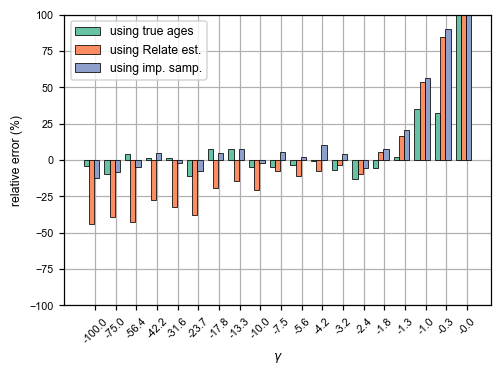

In [427]:
# plotting the difference in values as found using the true age, Relate estimate, importance sampling
listofgamflt = -np.array(listofgam[:20],dtype='float')
width = 0.5
plt.bar(np.arange(19)-width/2, (reswage[:-1,0]/2-listofgamflt[:-1])*100/listofgamflt[:-1], color = '#66c2a5',width = width/2, lw=0.5, edgecolor = 'black', label='using true ages')
plt.bar(np.arange(19), (reswage[:-1,1]/2-listofgamflt[:-1])*100/listofgamflt[:-1], color = '#fc8d62',width = width/2,lw=.5, edgecolor = 'black', label='using Relate est.')
plt.bar(np.arange(19) + width/2, (reswage[:-1,2]/2-listofgamflt[:-1])*100/listofgamflt[:-1], color = '#8da0cb', lw=.5,width = width/2, edgecolor = 'black', label='using imp. samp.')
plt.xticks(np.arange(19) + width/3,np.round(listofgamflt[:-1],1),rotation=45); plt.legend(); plt.xlabel(r'$\gamma$'); plt.ylabel('relative error (%)'); plt.grid(); plt.ylim((-100,100))
# plt.scatter(listofgamflt,(reswage[:,0]-listofgamflt)/listofgamflt,color='g',label='using true ages')
# plt.scatter(listofgamflt,(reswage[:,1]-listofgamflt)/listofgamflt,color='b',label='using Relate est.')
# plt.scatter(listofgamflt,(reswage[:,2]-listofgamflt)/listofgamflt,color='grey',label='using imp. samp.'); 

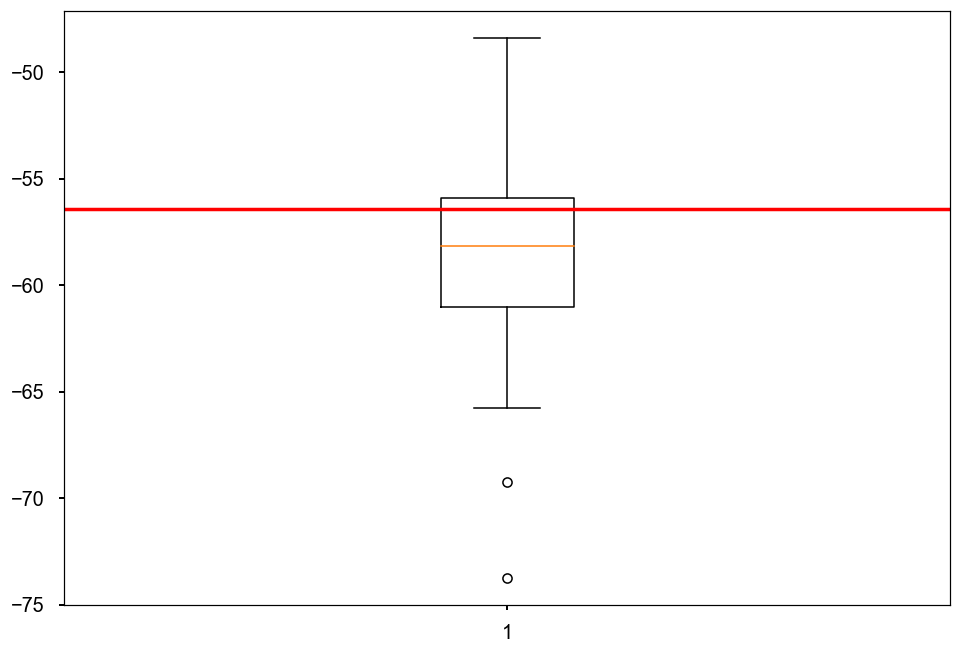

In [672]:
# width = 0.5
# plt.bar(np.arange(20)-width/2, reswage[:,0]/2-listofgamflt, color = '#66c2a5',width = width/2, lw=0.5, edgecolor = 'black', label='using true ages')
# plt.bar(np.arange(20), reswage[:,1]/2-listofgamflt, color = '#fc8d62',width = width/2, lw=0.5, edgecolor = 'black', label='using Relate est.')
# plt.bar(np.arange(20) + width/2, reswage[:,2]/2-listofgamflt, color = '#8da0cb', width = width/2, lw=0.5, edgecolor = 'black', label='using imp. samp.')
# plt.xticks(np.arange(20) + width/3,np.round(listofgamflt,2),rotation=45); plt.legend(); plt.xlabel(r'$\gamma$'); plt.ylabel('signed error'); plt.grid(); 
# finalres2.iloc[60-1,4]
# finalres0.iloc[int((i-400)/20),j]
plt.boxplot(finalres2.loc[finalres2['gamma']==56.423].iloc[:,5]); plt.axhline(-56.423,color='red')
# finalres0.loc[finalres0['tid']==480,:]

In [676]:
## reading in results from midway3 
# finalres2 = pd.concat([pd.read_csv('resfiles/finalRes2.csv',delimiter=','),pd.read_csv('resfiles/finalRes2023-03-01.csv',delimiter=','),pd.read_csv('resfiles/finalRes2023-03-02.csv',delimiter=','),pd.read_csv('resfiles/finalRes2023-03-03.csv',delimiter=',')])
# finalres2.to_csv('resfiles/finalResfinal.csv',index=False)
# finalres2
# finalres0 = pd.read_csv('resfiles/finalRes0.csv',delimiter=',')
# finalres56 = pd.read_csv('resfiles/finalRes56.423.csv',delimiter=',')
# finalres5 = pd.read_csv('resfiles/finalRes5.623.csv',delimiter=',')

# ta = np.reshape(finalres2.iloc[:,2].tolist(),(-1,50),order='F')[[0,8,16,19],:]
# rm = np.reshape(finalres2.iloc[:,3].tolist(),(-1,50),order='F')[[0,8,16,19],:]
# ims = np.reshape(finalres2.iloc[:,4].tolist(),(-1,50),order='F')[[0,8,16,19],:]
# fo = np.reshape(finalres2.iloc[:,5].tolist(),(-1,50),order='F')[[0,8,16,19],:]
# for i in np.r_[403:2003:20]:
#     for j in range(2,6):
#         finalres2.iloc[i-1,j] = finalres56.iloc[int((i-403)/20),j]

NameError: name 'rm' is not defined

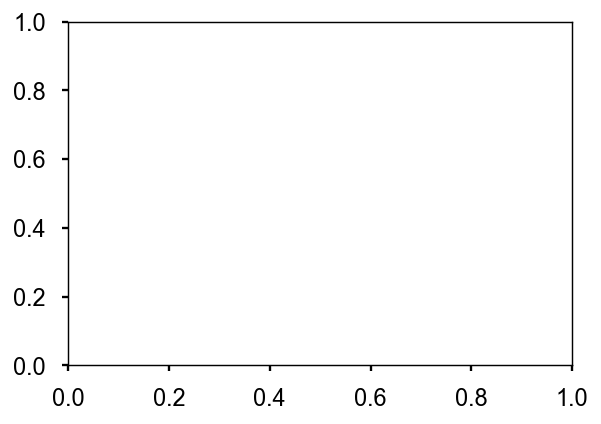

In [24]:
# np.mean((ta[:-1,].T-listofgamflt[:-1])*100/listofgamflt[:-1],axis=0)
# np.mean((ta[:-1,].T-listofgamflt[::3])*100/listofgamflt[:-1][::3],axis=0)
# plt.plot(listofgamflt,np.std(fo.T,axis=0)/np.std(ta.T,axis=0),'ko', alpha=0.7); plt.plot(listofgamflt,np.std(fo.T,axis=0)/np.std(ims.T,axis=0),'bo', alpha=0.7)
# plt.xscale('symlog'); plt.ylabel('ratio of SD'); plt.xlabel(r'$\gamma$'); plt.axhline(1,color='grey',ls='--'); 
def setViolColors(bp):
    bp['bodies'][0].set_facecolor('deepskyblue')
    bp['bodies'][0].set_alpha(0.8)
    bp['bodies'][0].set_linewidth(1)
    bp['cbars'].set_colors('grey')
    bp['cbars'].set_alpha(0.6)
    bp['cmins'].set_color('grey')
    bp['cmaxes'].set_color('grey')

    plt.setp(bp['bodies'][1], color='coral', alpha=0.8)

    plt.setp(bp['bodies'][2], color='#8da0cb', alpha=0.8)

    plt.setp(bp['bodies'][3], color='#66c2a5', alpha=0.8)

fig = plt.figure(dpi=130)
plt.style.use('seaborn-talk')
ax = plt.axes()
s = np.array([-100,-10,-1,0])
#-np.append(np.linspace(0.0, 1.0, num=10)**np.exp(1),np.geomspace(100,1,40,endpoint=False)[::-1])[::-1]#np.array([1,10,100]) 

for i in range(len(s)):
    # bp = plt.boxplot([parestfreq[i,~np.isnan(parestfreq[i,:])],parestage[i,~np.isnan(parestage[i,:])]],positions=[3*i+1,3*i+2], widths=0.6,flierprops=dict(marker='x',markersize=5,alpha=0.5),)
    # setBoxColors(bp)
    posn = [1,1.5,2,2.5,4,4.5,5,5.5,7,7.5,8,8.5,9.3,9.7,10.1,10.5]
    vp = plt.violinplot([fo[i,:],ta[i,:],rm[i,:],ims[i,:]],positions=[posn[4*i],posn[4*i+1],posn[4*i+2],posn[4*i+3]], widths=0.4,)
    setViolColors(vp)
    plt.axhline(s[i],color='grey',ls='--',alpha=0.6,lw=3)

# bp = plt.boxplot([parestfreq0,parestage0],positions=[16,17],widths=0.6,flierprops=dict(marker='x',markersize=5,alpha=0.5))
# setBoxColors(bp) 
# vp = plt.violinplot([-parestfreq[-1,:],-parestage[-1,:]],positions=[9,10],widths=0.6,)
# setViolColors(vp)
# plt.axhline(0.,color='grey',ls='--',alpha=0.6);

# ax.set_xticks([1.5,4.5,7.5,10.5,13.5,16.5]); ax.set_xticklabels(np.ravel(s.tolist()+[0.])); ax.set_yscale('symlog');
ax.set_xticks([1.75,4.75,7.75,9.75]); ax.set_xticklabels(np.ravel(s.tolist())); 
ax.set_yscale('symlog'); ax.set_yticks(s,labels=[-100,-10,-1,0]); 

hB, = plt.plot(0,0,color='deepskyblue'); hR, = plt.plot(0,0,color='coral'); hC, = plt.plot(0,0,color='#8da0cb'); hS, = plt.plot(0,0,color='#66c2a5'); 
plt.xlabel(r'$\gamma$ (true value)'); plt.ylabel(r'$\hat \gamma$ (MLE value, 100 replicates)'); plt.legend((hB, hR),('freq only','freq & age'),loc='upper left')
plt.legend((hB, hR, hC, hS),('freq only, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(-s+1)-np.log10(np.mean(-fo+1,axis=1)))**2))), 'true age, RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(-s+1)-np.log10(np.mean(-ta+1,axis=1)))**2))), 'Relate est., RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(-s+1)-np.log10(np.mean(-rm+1,axis=1)))**2))), 'imp. samp., RMSLE: {:.2f}'.format(np.sqrt(np.mean((np.log10(-s+1)-np.log10(np.mean(-ims+1,axis=1)))**2)))),loc='upper left'); plt.grid()
# plt.savefig("../figs/MLEfreqage2.pdf")

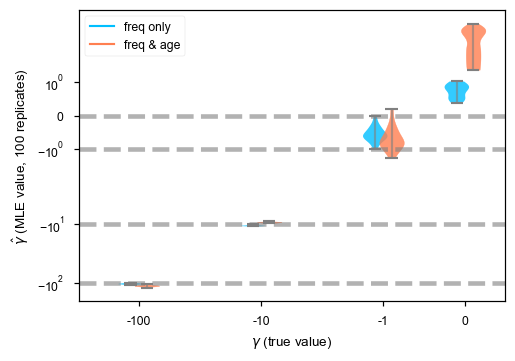

In [225]:
# import pyreadr
# FIN = pyreadr.read_r('~/Downloads/allele_ages_EUR/allele_ages_FIN.RData')['allele_ages']
# plt.hist(0.5*(FIN['lower_age']+FIN['upper_age']),100); plt.semilogy()

# dft = pd.read_csv('~/selCoefEst/PReFerSims/resfiles/finalRes2023-04-11.csv')
# ga = np.reshape(dft.iloc[:,1].tolist(),(-1,20),order='F')#[[0,15,30,34],:]
# ta = np.reshape(dft.iloc[:,2].tolist(),(-1,20),order='F')#[[0,15,30,34],:]
# fo = np.reshape(dft.iloc[:,3].tolist(),(-1,20),order='F')#[[0,15,30,34],:]

# def setViolColors(bp):
#     bp['bodies'][0].set_facecolor('deepskyblue')
#     bp['bodies'][0].set_alpha(0.8)
#     bp['bodies'][0].set_linewidth(1)
#     bp['cbars'].set_colors('grey')
#     bp['cbars'].set_alpha(0.6)
#     bp['cmins'].set_color('grey')
#     bp['cmaxes'].set_color('grey')

#     plt.setp(bp['bodies'][1], color='coral', alpha=0.8)

# fig = plt.figure(dpi=130)
# plt.style.use('seaborn-talk')
ax = plt.axes()
s = np.array([-100,-10,-1,0])

for i in range(len(s)):
    posn = [0.8,1.2,3.8,4.2,6.8,7.2,8.8,9.2]
    vp = plt.violinplot([fo[i,:],ta[i,:]],positions=[posn[2*i],posn[2*i+1]], widths=0.6,)
    setViolColors(vp)
    plt.axhline(s[i],color='grey',ls='--',alpha=0.6,lw=3)

# ax.set_xticks([1.5,4.5,7.5,10.5,13.5,16.5]); ax.set_xticklabels(np.ravel(s.tolist()+[0.])); ax.set_yscale('symlog');
ax.set_xticks([1,4,7,9]); ax.set_xticklabels(np.ravel(s.tolist())); 
ax.set_yscale('symlog'); #ax.set_yticks(s,labels=[-100,-10,-1,0]); 

hB, = plt.plot(0,0,color='deepskyblue'); hR, = plt.plot(0,0,color='coral'); 
plt.xlabel(r'$\gamma$ (true value)'); plt.ylabel(r'$\hat \gamma$ (MLE value, 100 replicates)'); plt.legend((hB, hR),('freq only','freq & age'),loc='upper left')

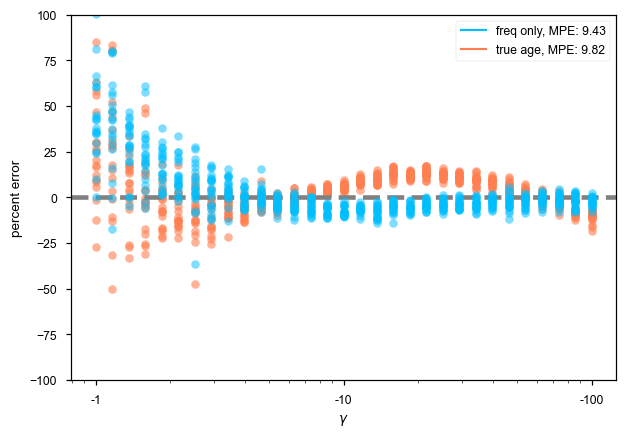

In [217]:
# plt.plot(ga[:31,0],(ga[:31,:]+ta[:31,:])*100/ga[:31,:],'o',alpha=0.6,color='coral'); plt.axhline(0,color='grey',ls='--',lw=3);
# hB, = plt.plot(0,0,color='deepskyblue',label='freq only'); hR, = plt.plot(0,0,color='coral',label='freq & age');
# plt.legend((hB, hR),('freq only, MPE: {:.2f}'.format(np.mean(np.abs((ga[:31,:]+fo[:31,:])*100/ga[:31,:]))), 'true age, MPE: {:.2f}'.format(np.mean(np.abs((ga[:31,:]+ta[:31,:])*100/ga[:31,:])))),loc='best'); plt.plot(ga[:31,0],(ga[:31,:]+fo[:31,:])*100/ga[:31,:],'o',alpha=0.5,color='deepskyblue'); plt.ylim((-100,100))
# plt.semilogx(); plt.xticks([1,10,100],['-1','-10','-100']); plt.xlabel(r'$\gamma$'); plt.ylabel(r'percent error'); 

# plt.plot(ga[:31,0],np.abs(ga[:31,:]+ta[:31,:]),'o',alpha=0.6,color='coral'); plt.axhline(0,color='grey',ls='--',lw=3);
# hB, = plt.plot(0,0,color='deepskyblue',label='freq only'); hR, = plt.plot(0,0,color='coral',label='freq & age');
# plt.legend((hB, hR),('freq only, RMSE: {:.2f}'.format(np.sqrt(np.mean((ga[:31,:]+fo[:31,:])**2))), 'true age, RMSE: {:.2f}'.format(np.sqrt(np.mean((ga[:31,:]+ta[:31,:])**2)))),loc='best'); plt.plot(ga[:31,0],np.abs(ga[:31,:]+fo[:31,:]),'o',alpha=0.5,color='deepskyblue'); plt.semilogx() 
# plt.xticks([1,10,100],['-1','-10','-100']); plt.xlabel(r'$\gamma$'); plt.ylabel(r'absolute error'); 

# plt.errorbar(-ga[:31,0],np.mean((ga[:31,:]+fo[:31,:])**2,axis=1),yerr=np.std((ga[:31,:]+fo[:31,:])**2,axis=1),color='deepskyblue',alpha=0.8,fmt='o',label='freq only'); plt.errorbar(-ga[:31,0],np.mean((ga[:31,:]+ta[:31,:])**2,axis=1),yerr=np.std((ga[:31,:]+ta[:31,:])**2,axis=1),color='coral',alpha=0.8,fmt='o',label='freq & age'); plt.legend(); plt.ylabel('MSE'); plt.axhline(0,color='grey',ls='--',); plt.xscale('symlog'); plt.xlim((-120,-0.9)); plt.grid()

# plt.style.use('seaborn-paper')
# plt.errorbar(-ga[:31,0],np.mean(np.log(-ga[:31,:]/fo[:31,:]),axis=1),yerr=np.std(np.log(-ga[:31,:]/fo[:31,:]),axis=1),color='deepskyblue',alpha=0.8,fmt='o',label='freq only'); plt.errorbar(-ga[:31,0],np.mean(np.log(-ga[:31,:]/ta[:31,:]),axis=1),yerr=np.std(np.log(-ga[:31,:]/ta[:31,:]),axis=1),color='coral',alpha=0.8,fmt='o',label='freq & age'); plt.legend(); plt.ylabel(r'$\log(\frac{\hat \gamma}{\gamma})$'); plt.axhline(0,color='grey',ls='--',); plt.xscale('symlog'); plt.xlim((-120,-0.9)); plt.grid()

# plt.style.use('seaborn-poster')
# plt.errorbar(-ga[:31,0],np.mean((ga[:31,:]+fo[:31,:])*100/ga[:31,:],axis=1),yerr=np.std((ga[:31,:]+fo[:31,:])*100/ga[:31,:],axis=1),color='deepskyblue',alpha=0.8,fmt='o',label='freq only'); plt.errorbar(-ga[:31,0],np.mean((ga[:31,:]+ta[:31,:])*100/ga[:31,:],axis=1),yerr=np.std((ga[:31,:]+ta[:31,:])*100/ga[:31,:],axis=1),color='coral',alpha=0.8,fmt='o',label='freq & age'); plt.legend(); plt.ylabel('Mean Percent Error'); plt.axhline(0,color='grey',ls='--',); plt.xscale('symlog'); plt.xlim((-120,-0.9)); plt.grid()

# plt.plot(-ga[:,0],np.std(fo.T,axis=0)/np.std(ta.T,axis=0),'ko', alpha=0.7); 
# plt.xscale('symlog'); plt.ylabel('ratio of SD'); plt.xlabel(r'$\gamma$'); plt.axhline(1,color='grey',ls='--'); 

# np.mean((ta.T-listofgamflt)**2,axis=0), np.mean((rm.T-listofgamflt)**2,axis=0), np.mean((fo.T-listofgamflt)**2,axis=0), np.mean((ims.T-listofgamflt)**2,axis=0)
# np.std(ta.T-listofgamflt,axis=0), np.std(rm.T-listofgamflt,axis=0), np.std(fo.T-listofgamflt,axis=0), np.std(ims.T-listofgamflt,axis=0)
# width = 0.8
# plt.bar(3*np.arange(19)-width,np.mean((ta[:-1,].T-listofgamflt[:-1])*100/listofgamflt[:-1],axis=0),color = '#66c2a5',width = width,lw=0.5, edgecolor = 'black', label='using true ages')
# plt.bar(3*np.arange(19)-width/2,np.mean((rm[:-1,].T-listofgamflt[:-1])*100/listofgamflt[:-1],axis=0), color = '#fc8d62',width = width,lw=.5, edgecolor = 'black', label='using Relate est.')
# plt.bar(3*np.arange(19)+width/2,np.mean((ims[:-1,].T-listofgamflt[:-1])*100/listofgamflt[:-1],axis=0), color = '#8da0cb', lw=.5,width = width, edgecolor = 'black', label='using imp. samp.')
# plt.bar(3*np.arange(19)+width,np.mean((fo[:-1,].T-listofgamflt[:-1])*100/listofgamflt[:-1],axis=0), color = '#e78ac3',width = width,lw=.5, edgecolor = 'black', label='using freq. only')
# plt.xticks(3*np.arange(19),np.round(listofgamflt[:-1],1),rotation=45); plt.legend(); plt.xlabel(r'$\gamma$'); plt.ylabel('relative error (%)'); plt.grid(); plt.ylim((-50,50))

## Calculating the expected gain in information 

From a uniform prior (i.e., no information) to adding frequency,
$$
\mathcal{I_f}(s^*) = \int \bigg( \int P(s | X) \log \frac{P(s|X)}{P(s_0)} ds \bigg) P(X|s^*) dX \\
\mathcal{I_f}(s^*) \approx \sum_{i=1}^{2n-1} \bigg(\sum_{j=0}^{m} P(s_j | i) \log \frac{P(s_j|i)}{P(s_0)} \Delta s \bigg) P(i|s^*)  \\
\mathcal{I_f}(s^*) \approx \sum_{i=1}^{2n-1} \bigg(\sum_{j=1}^{m} \frac{P(i | s_j) P(s_j)}{P(i)} \log \frac{P(i|s_j)}{P(i)} \Delta s \bigg) P(i|s^*)\\
\Delta s = s_{j+1} - s_j \forall j \in \{1,2,\ldots,m-1\} \& \Delta s \to 0 \\
s_0 \sim \text{Unif}(0,-1000) \\
P(i) \approx \sum_j P(i|s_j)P(s_j) \Delta s
$$

From knowing frequency to adding ages,
$$
\int \int \bigg( \int P(s | X, a) \log \frac{P(s|X,a)}{P(s|X)} ds \bigg) P(X, a|s^*) dX da \\
P(s|X,a) = \frac{P(X,a|s) P(s)}{P(X,a)} \\ 
\mathcal{I_a}(s^*) \approx \sum_{a=0}^{\infty} \sum_{i=1}^{2n-1} \bigg(\sum_{j=1}^{m} \frac{P(i, a | s_j) P(s_j)}{P(i,a)} \log \frac{P(i, a|s_j)P(i)}{P(i,a)P(i|s_j)} \Delta s \bigg) P(i,a|s^*)\\
s_0 \sim \text{Unif}(0,-1000)
$$


In [338]:
def get_info_gainf(s0, bigpofi, n=200):
    # if s0 < -50:
    #     theta = 400
    # elif s0 > -5 and s0 <= -50:
    #     theta = 200
    # else:
    #     theta = 100
    theta=100
    
    sfs0 = moments.LinearSystem_1D.steady_state_1D(2000, gamma=s0, theta=theta)
    sfs0 = moments.Spectrum(sfs0)
    sfs0.integrate([1], 4, gamma=s0, theta=theta) ## for PReFerSim, we need 0.5Ne instead of Ne
    sfs0 = sfs0.project([n]) 

    psfs0 = sfs0/sfs0.sum()

    return np.sum(bigpofi[1:-1] * psfs0[1:-1])

def get_info_gainff(s0, bigpofi, freq, n=200):
    theta=100
    
    sfs0 = moments.LinearSystem_1D.steady_state_1D(2000, gamma=s0, theta=theta)
    sfs0 = moments.Spectrum(sfs0)
    sfs0.integrate([1], 4, gamma=s0, theta=theta) ## for PReFerSim, we need 0.5Ne instead of Ne
    sfs0 = sfs0.project([n]) 

    psfs0 = sfs0/sfs0.sum()

    return bigpofi[freq] * psfs0[freq]

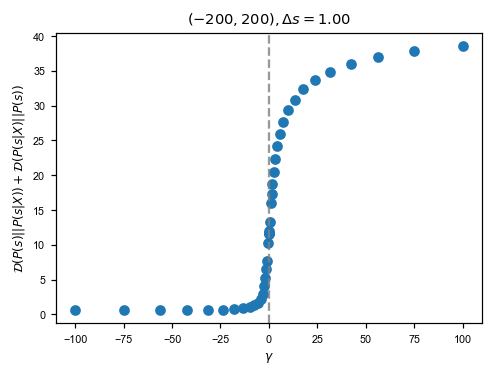

In [573]:
## total: 30 s for 200 sj
# sj, deltas = np.linspace(-200,200,num=400,retstep=True)

# psfsj = np.zeros((len(sj),201))
# for j, s in enumerate(sj):
#     sfsj = moments.LinearSystem_1D.steady_state_1D(2000, gamma=s, theta=100)
#     sfsj = moments.Spectrum(sfsj)
#     sfsj.integrate([1], 3, gamma=s, theta=100) 
#     sfsj = sfsj.project([200]) 

#     psfsj[j] = sfsj/sfsj.sum()

# plt.imshow(psfsj[:400,1:-1],aspect='auto',norm=colors.LogNorm(vmax=1,vmin=1e-10),cmap='viridis',interpolation_stage='rgba'); plt.colorbar(); plt.xlabel('allele freq (i)'); plt.yticks(range(0,400,20),np.around(sj[range(0,400,20)],1)); plt.ylabel(r'$s_j$'); plt.title(r'$P(i|s_j)$')
# plt.imshow(psfsj[:,1:-1],aspect='auto',vmin=0.0001,vmax=0.005,cmap='viridis',interpolation_stage='rgba'); plt.colorbar(); plt.xlabel('allele freq (i)'); plt.yticks(range(0,200,20),np.around(sj[range(00,200,20)],1)); plt.ylabel(r'$s_j$'); plt.title(r'$P(i|s_j)$')

# plt.plot(psfsj[50,1:-1],psfsj[150,1:-1],'ko'); plt.axline((0,0),slope=1); plt.xlabel(r's = {:.1f}'.format(sj[50])); plt.ylabel(r's = {:.1f}'.format(sj[150])); plt.loglog()

# pofi = np.sum(psfsj,axis=0) * deltas/len(sj)

# bigpofi = np.zeros(201)
# for i in range(1,200):
#     bigpofi[i] = np.sum(psfsj[:,i]/(len(sj)*pofi[i]) * (np.log(psfsj[:,i]) - np.log(len(sj)) + np.log(400) - np.log(pofi[i])) * deltas)

# bigpofirev = np.zeros(201)
# for i in range(1,200):
#     bigpofirev[i] = np.sum(1/400 * (np.log(1/400) + np.log(pofi[i]) - np.log(psfsj[:,i]) - np.log(1/len(sj)))) * deltas

# expgainf = np.zeros(40)
# for ig, gam in enumerate(np.append(-np.append(np.linspace(0.0, 1.0, num=4)**np.exp(1),np.geomspace(100,1,16,endpoint=False)[::-1]),np.append(np.linspace(0.0, 1.0, num=4)**np.exp(1),np.geomspace(100,1,16,endpoint=False)[::-1]))):
#     expgainf[ig] = get_info_gainf(gam,bigpofi) + get_info_gainf(gam,bigpofirev) 

plt.plot(np.append(-np.append(np.linspace(0.0, 1.0, num=4)**np.exp(1),np.geomspace(100,1,16,endpoint=False)[::-1]),np.append(np.linspace(0.0, 1.0, num=4)**np.exp(1),np.geomspace(100,1,16,endpoint=False)[::-1])),expgainf,'o'); plt.xlabel(r'$\gamma$'); plt.ylabel(r'$\mathcal{D}(P(s) || P(s|X)) + \mathcal{D}(P(s|X) || P(s))$'); plt.axvline(0,color='grey',alpha=0.8,ls='--'); plt.title(r'$(-200,200), \Delta s={:.2f}$'.format(deltas)); 

[]

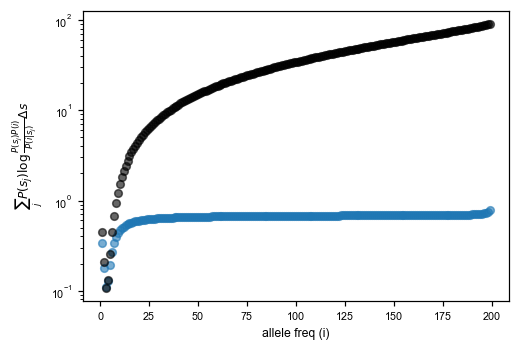

In [584]:
# plt.plot(range(1,200),bigpofi[1:-1],'o',alpha=0.6,markersize=5); plt.grid(); plt.xlabel('allele freq (i)'); plt.ylabel(r'$\sum_j \frac{P(i|s_j) P(s_j)}{P(i)} \log \frac{P(i|s_j)}{P(i)} \Delta s$'); 
# plt.plot(range(1,200),bigpofirev[1:-1],'ko',alpha=0.6,markersize=5); plt.grid(); plt.xlabel('allele freq (i)'); plt.ylabel(r'$\sum_j P(s_j) \log \frac{P(s_j) P(i)}{P(i|s_j)} \Delta s$'); plt.semilogy()

# plt.plot(range(1,200),pofi[1:-1],'ko',alpha=0.6,markersize=5); plt.grid(); plt.xlabel('allele freq (i)'); plt.ylabel(r'$P(i) = \sum_j P(i|s_j)P(s_j) \Delta s$'); plt.semilogy()

## for a particular frequency, say 10%, what does the slice look like?
# expgainff = np.zeros(40)
# for ig, gam in enumerate(np.append(-np.append(np.linspace(0.0, 1.0, num=4)**np.exp(1),np.geomspace(100,1,16,endpoint=False)[::-1]),np.append(np.linspace(0.0, 1.0, num=4)**np.exp(1),np.geomspace(100,1,16,endpoint=False)[::-1]))):
#     expgainff[ig] = get_info_gainff(gam,bigpofi,20) + get_info_gainff(gam,bigpofirev,20)

# plt.plot(np.append(-np.append(np.linspace(0.0, 1.0, num=4)**np.exp(1),np.geomspace(100,1,16,endpoint=False)[::-1]),np.append(np.linspace(0.0, 1.0, num=4)**np.exp(1),np.geomspace(100,1,16,endpoint=False)[::-1])),expgainff,'o'); plt.xlabel(r'$\gamma$'); plt.ylabel(r'$\mathcal{D}(P(s|X) || P(s)), X = 10\%$'); plt.axvline(0,color='grey',alpha=0.8,ls='--'); 

NameError: name 'xplt' is not defined

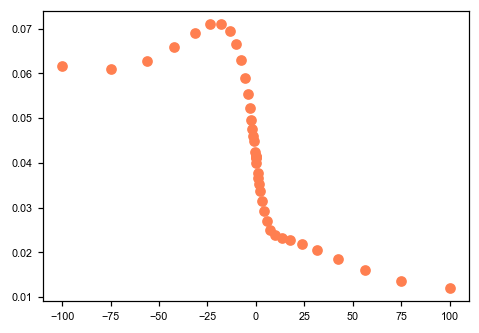

: 

In [616]:
## loooong time: 4.5 mins for 1000 sj
# psfasj = np.zeros((len(sj),20000,201))
# for j, s in enumerate(sj):
#     sfasj = run_mom_iterate_constant(20000, 200, s/10000, 10000, 100, {})
#     psfasj[j] = sfasj/sfasj.sum()
#     psfasj[j][psfasj[j]<0] = 0

# plt.imshow(psfasj[177],aspect='auto',norm=colors.LogNorm(vmax=1,vmin=1e-20),cmap='viridis',interpolation_stage='rgba')

## short time: 36 s for 1000 sj
# pofai = np.nansum(psfasj,axis=0)/len(sj) * deltas
# pofai[pofai<0] = 0

## loong time: 3 mins for 1000 sj & 20000 gens
# temp = np.zeros_like(psfasj[0])
# for j in range(180):
#     temp[:,1:-1] += psfasj[j,:,1:-1]/(len(sj)*pofai[:,1:-1]) * (np.log(psfasj[j,:,1:-1]) + np.log(np.tile(pofi[1:-1],(20000,1))) - np.log(pofai[:,1:-1]) - np.log(np.tile(psfsj[j,1:-1],(20000,1)))) * deltas
# bigpofai = deepcopy(temp)
# bigpofai

# for j in range(180):
#     temp[:,1:-1] += np.tile(psfsj[j,1:-1],(20000,1)) / (len(sj) * np.tile(pofi[1:-1],(20000,1))) * (np.log(np.tile(psfsj[j,1:-1],(20000,1))) + np.log(pofai[:,1:-1]) - np.log(np.tile(pofi[1:-1],(20000,1))) - np.log(pofai[:,1:-1])) * deltas
# bigpofairev = deepcopy(temp)
# bigpofairev

expgaina = np.zeros(40)
for ig, gam in enumerate(np.append(-np.append(np.linspace(0.0, 1.0, num=4)**np.exp(1),np.geomspace(100,1,16,endpoint=False)[::-1]),np.append(np.linspace(0.0, 1.0, num=4)**np.exp(1),np.geomspace(100,1,16,endpoint=False)[::-1]))):
    expgaina[ig] = get_info_gaina(gam,bigpofai) #+ get_info_gaina(gam,bigpofairev)

plt.plot(np.append(-np.append(np.linspace(0.0, 1.0, num=4)**np.exp(1),np.geomspace(100,1,16,endpoint=False)[::-1]),np.append(np.linspace(0.0, 1.0, num=4)**np.exp(1),np.geomspace(100,1,16,endpoint=False)[::-1])),expgaina,'o',color='coral',label=r'$\mathcal{D}(P(s|X,a)||P(s|X))$'); 
plt.plot(np.append(-np.append(np.linspace(0.0, 1.0, num=4)**np.exp(1),np.geomspace(100,1,16,endpoint=False)[::-1]),np.append(np.linspace(0.0, 1.0, num=4)**np.exp(1),np.geomspace(100,1,16,endpoint=False)[::-1])),expgainf,'o',color='deepskyblue',label=r'$\mathcal{D}(P(s|X)||P(s))$'); 
plt.grid(); plt.xlabel(r'$\gamma$'); plt.axvline(0,color='grey',alpha=0.8,ls='--'); plt.legend(loc='upper left')